In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
import warnings; warnings.simplefilter('ignore')

# Importing Data

In [0]:
d=pd.read_csv('concrete.csv')

In [7]:
d.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


● Cement : measured in kg in a m3 mixture
● Blast : measured in kg in a m3 mixture
● Fly ash : measured in kg in a m3 mixture
● Water : measured in kg in a m3 mixture
● Superplasticizer : measured in kg in a m3 mixture
● Coarse Aggregate : measured in kg in a m3 mixture
● Fine Aggregate : measured in kg in a m3 mixture
● Age : day (1~365)
● Concrete compressive strength measured in MPa


In [8]:
d.dtypes

cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object

In [9]:
d.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

The data has no missing values

In [10]:
description=d.describe().transpose()
description

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [11]:
description['mean']-description['50%']

cement           8.267864
slag            51.895825
ash             54.188350
water           -3.432718
superplastic    -0.195340
coarseagg        4.918932
fineagg         -5.919515
age             17.662136
strength         1.372961
dtype: float64

In [12]:
skew=d.skew()
skew.sort_values() 

fineagg        -0.253010
coarseagg      -0.040220
water           0.074628
strength        0.416977
cement          0.509481
ash             0.537354
slag            0.800717
superplastic    0.907203
age             3.269177
dtype: float64

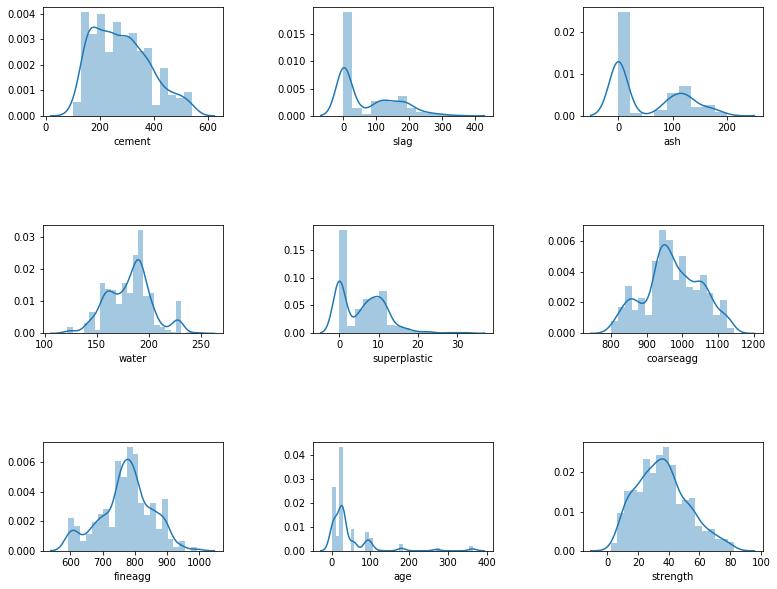

In [13]:
k=1
plt.figure(figsize=(10,10))
for features in d.columns:
    plt.subplot(3,3,k)
    sns.distplot(d[features])
    plt.subplots_adjust(left=0,right=1,wspace=0.5,hspace=1)
    k=k+1

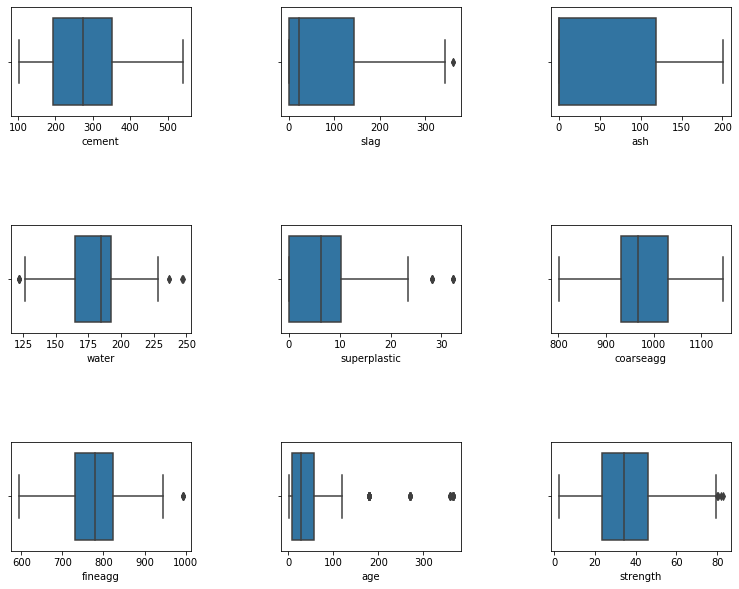

In [14]:
k=1
plt.figure(figsize=(10,10))
for features in d.columns:
    plt.subplot(3,3,k)
    sns.boxplot(d[features])
    plt.subplots_adjust(left=0,right=1,wspace=0.5,hspace=1)
    k=k+1

Cement : The distribution is good, no outliers, Seems to have only one gaussian

Slag : There is a outlier above upper quartile.The Distribution is skewed and looks like it has 2 gaussian

ash :  There is no outlier. The Distribution is skewed and looks like it has 2 gaussian

Water : There is outlier in both upper and lower quartiles. Distribution is less skewed but seems to have 3 gaussions

Superplastic : There is a outlier above upper quartile.The Distribution is skewed and looks like it has 2 gaussian

Coarseagg: There is outlier in both upper and lower quartiles. Distribution is less skewed but seems to have 3 gaussions

fineagg: There is a outlier above upper quartile. Seems to have 2 gaussians

Age: There are outliers above the upper quartile zones. the Data seems to have multiple gaussians. It might be useful to try and converte age to months. lets try it

Strength : The target variable. Seems like there are few outliers in upper quartile zone.




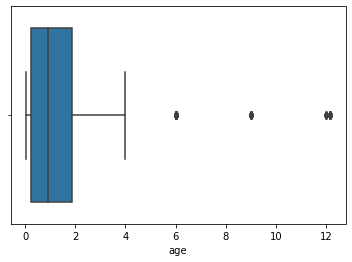

In [15]:
month=d['age']/30
sns.boxplot(month)

(945, 9)
(85, 9)


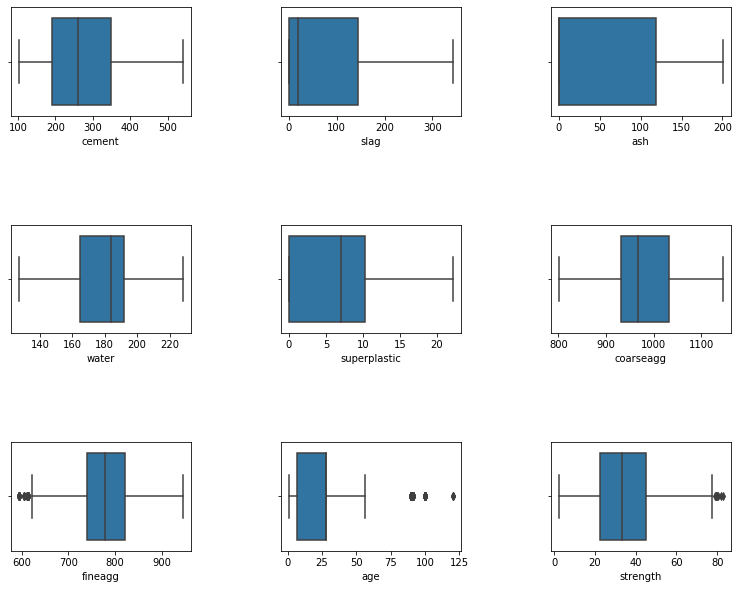

In [16]:
Q1=d.quantile(0.25)
Q3=d.quantile(0.75)
IQR=Q3-Q1
d1=d.iloc[:,:-1]
d_clean=d[~((d1<(Q1-1.5*IQR))|(d1>(Q3+1.5*IQR))).any(axis=1)]
k=1
plt.figure(figsize=(10,10))
for features in d.columns:
    plt.subplot(3,3,k)
    sns.boxplot(d_clean[features])
    plt.subplots_adjust(left=0,right=1,wspace=0.5,hspace=1)
    k=k+1
print(d_clean.shape)
d_outliers=d[((d1<(Q1-1.5*IQR))|(d1>(Q3+1.5*IQR))).any(axis=1)]
print(d_outliers.shape)

The generation of new outliers in the fineagg and age attributes is due to change in distribution. as they are not large compared to the previous case when can live with it.

But the number of outliers is approx. 10% of data. so we cannot drop them. we have to find a way to handle then like replacing with different values or taking log,sqrt etc. 

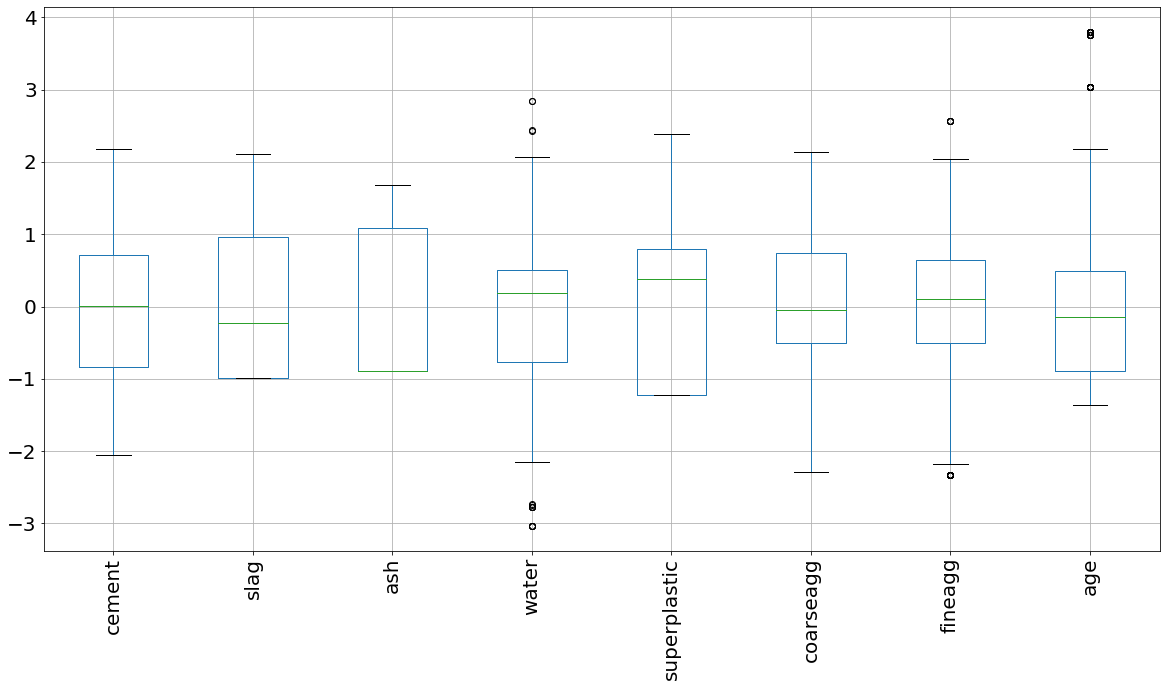

(984, 8)


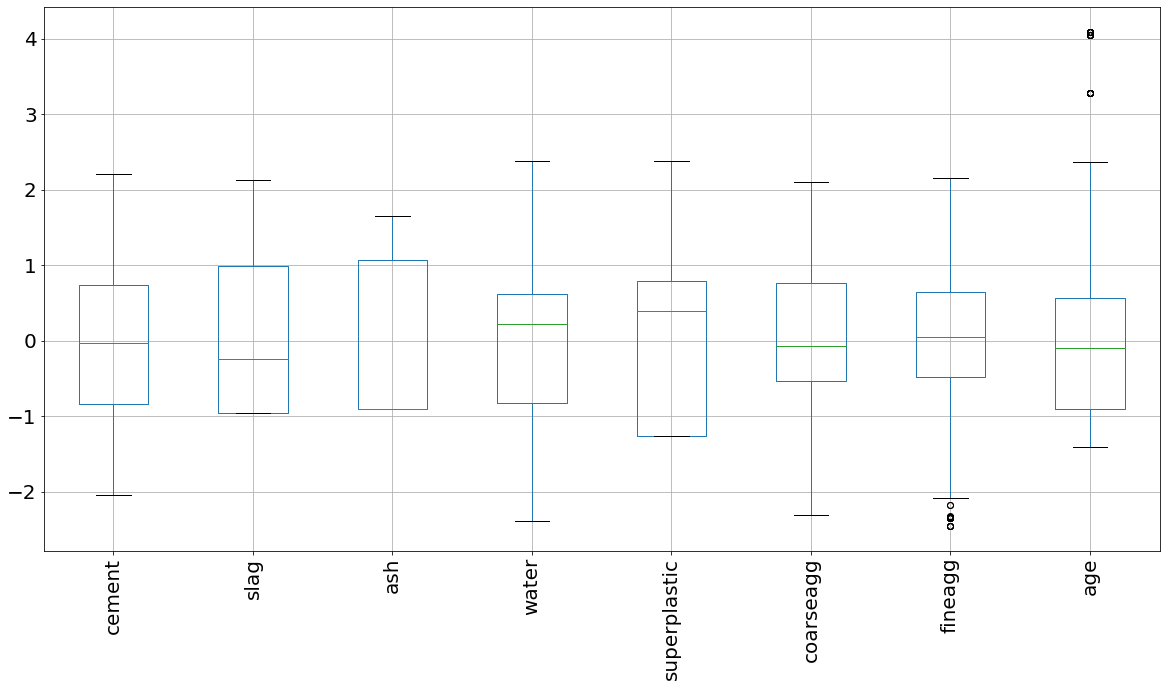

In [17]:
dff=d.iloc[:,:-1].apply(np.sqrt)
dff_scaled=dff.apply(zscore)
dff_scaled.boxplot(figsize=(20,10),rot=90,fontsize=20)
Q1=dff.quantile(0.25)
Q3=dff.quantile(0.75)
plt.show()
IQR=Q3-Q1
d1=dff.iloc[:,:-1]
d_clean1=dff[~((d1<(Q1-1.5*IQR))|(d1>(Q3+1.5*IQR))).any(axis=1)]
dff_scaled=d_clean1.apply(zscore)
dff_scaled.boxplot(figsize=(20,10),rot=90,fontsize=20)
print(dff_scaled.shape)
plt.show()

applying sqrt and then eliminatng outlier data helps in retaining more data.lets study the outlier data to understand more.

In [18]:
display(d_outliers)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.20
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
...,...,...,...,...,...,...,...,...,...
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42
995,380.0,0.0,0.0,228.0,0.0,932.0,670.0,365,52.52
1017,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,180,44.21
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30


# Identifying duplicates

In [19]:
d_noduplicate=d.drop_duplicates()
d_noduplicate.shape

(1005, 9)

It seems there are duplicates in the Data set. 25 duplicate sets

# BI-variate analysis

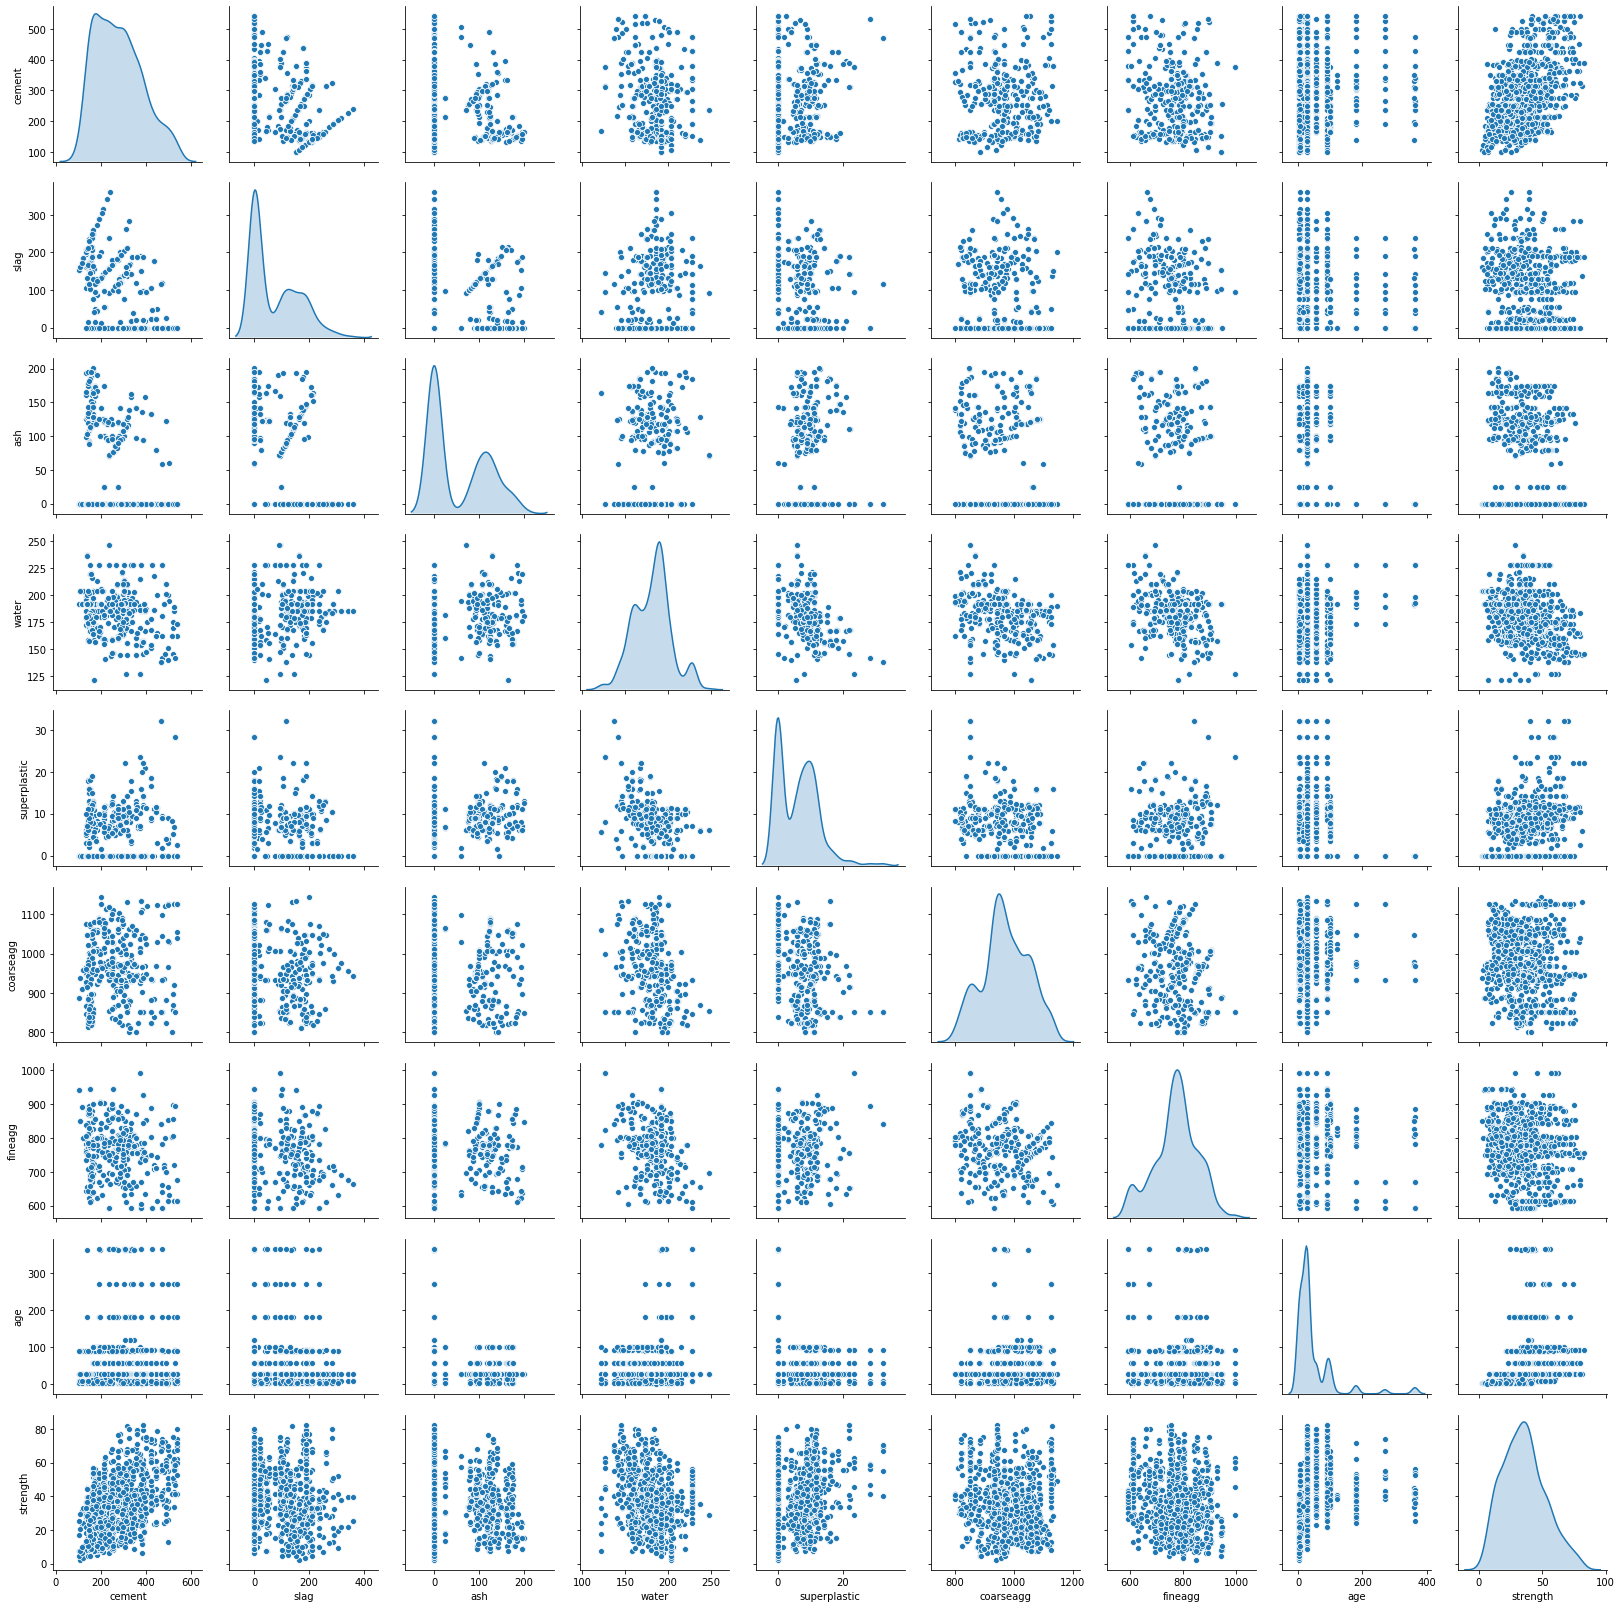

In [20]:
sns.pairplot(d,diag_kind='kde')

As already discussed, The KDE shows the presence of multiple gaussians in the attributes.

Only cement attribute shows increasing trend of strength

All other attributes with strength seems to show no strong trend. some very minor trends are superplastic and fine aggregate seems to have negative trend with water quantity,but not so strong.

 It just means that the strength cannot be preidct by just that attribute alone. Combination of attribute matters. By combining different things at different proportions same strength can be achieved. That is strength increases with aging, that same strength can be achieved in less time by adding say superplastic or increasing cement quantity, It has be verified by further analysis. lets study with objective measurements from correlation plot


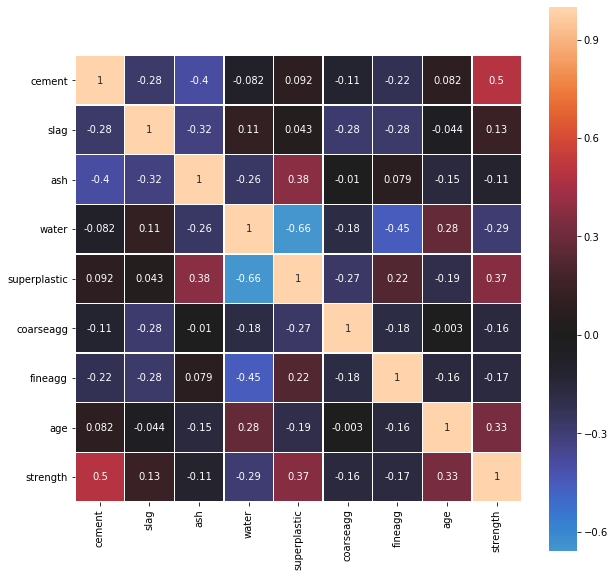

In [21]:
corr=d.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,square=True,annot=True,center=0,linewidths=0.5)

1)The correlation between cement and strength is 0.5 

2)Water has negative correlation with strength which seems logical, if we add more water the strength will come down

3) Ash, Coarseagg, fine aggregate  seems to have negative correlation with strength

4) Water seems to have hogh negative correlation with superplastics, but no idea why

5)superplastic and aging has positive correlation with strength,which is a known fact, strength increases if mixer is allowed to cure for longer time and superplastic acts as a strengthening agent

6) The correlations are not high enough so it seems PCA or clustering will not be useful, lets see

## Lets analyse the mixer combination for low and high strength 

In [0]:
lowstrengthmix=d[d['strength']<=20]
highstrengthmix=d[d['strength']>=60]

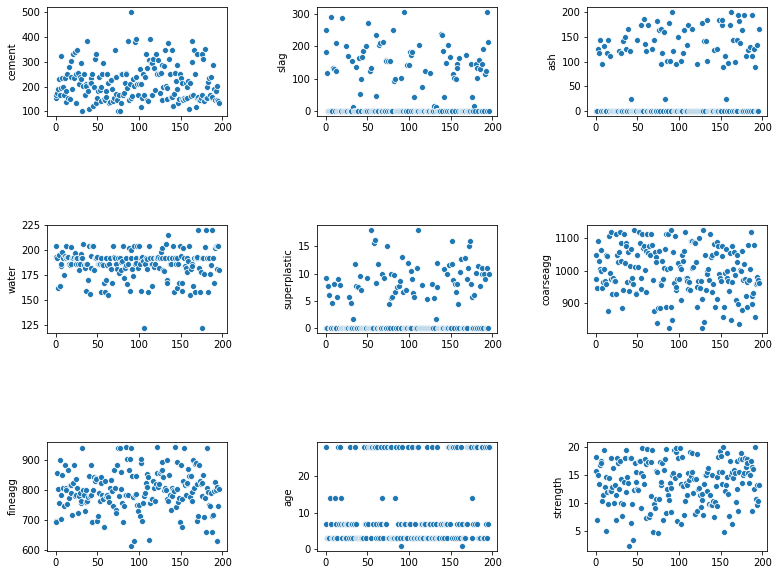

In [23]:
k=1
plt.figure(figsize=(10,10))
for features in d.columns:
    plt.subplot(3,3,k)
    sns.scatterplot(x=np.array(range(0,lowstrengthmix.shape[0])),y=lowstrengthmix[features])
    plt.subplots_adjust(left=0,right=1,wspace=0.5,hspace=1)
    k=k+1

The cement value is almost below 300, some cases cement value is above 300 but the strength is low why is that. lets see that dataset

In [24]:
lowstrengthmix[lowstrengthmix['cement']>300]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
38,325.0,0.0,0.0,184.0,0.0,1063.0,783.0,7,17.54
114,302.0,0.0,0.0,203.0,0.0,974.0,817.0,14,18.13
120,331.0,0.0,0.0,192.0,0.0,978.0,825.0,7,16.26
134,339.0,0.0,0.0,197.0,0.0,968.0,781.0,3,13.22
162,349.0,0.0,0.0,192.0,0.0,1047.0,806.0,7,18.13
218,385.0,0.0,0.0,186.0,0.0,966.0,763.0,3,14.70
261,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,7,17.24
265,333.0,0.0,0.0,192.0,0.0,931.2,842.6,3,15.62
382,349.0,0.0,0.0,192.0,0.0,1056.0,809.0,7,9.01
475,382.0,0.0,0.0,186.0,0.0,1111.0,784.0,7,11.47


5 things thats is common in this category is that the slag content is zero, Ash content is zero, Superplastic is zero and age is less than 15 days and Water content is on an average 200

In [25]:
lowstrengthmix[lowstrengthmix['cement']>300].corr()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.202000,NaN,0.014720,NaN,0.391686,-0.615859,-0.361237,-0.068850
slag,-0.202000,1.000000,NaN,0.307688,NaN,-0.127313,-0.573257,-0.113059,-0.033512
ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
water,0.014720,0.307688,NaN,1.000000,NaN,-0.159253,-0.351027,0.037678,0.233296
superplastic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coarseagg,0.391686,-0.127313,NaN,-0.159253,NaN,1.000000,-0.244911,0.163355,-0.108483
fineagg,-0.615859,-0.573257,NaN,-0.351027,NaN,-0.244911,1.000000,0.306384,0.058254
age,-0.361237,-0.113059,NaN,0.037678,NaN,0.163355,0.306384,1.000000,0.383288
strength,-0.068850,-0.033512,NaN,0.233296,NaN,-0.108483,0.058254,0.383288,1.000000


In [27]:
lowstrengthmix[lowstrengthmix['age']>20]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
106,155.0,0.0,143.0,193.0,9.0,877.0,868.0,28,9.74
108,151.6,0.0,111.9,184.4,7.9,992.0,815.9,28,12.18
175,238.1,0.0,0.0,185.7,0.0,1118.8,789.3,28,17.58
204,164.6,0.0,150.4,181.6,11.7,1023.3,728.9,28,18.03
248,200.0,0.0,0.0,180.0,0.0,1125.0,845.0,28,12.25
271,154.8,0.0,142.8,193.3,9.1,1047.4,696.7,28,12.46
290,238.0,0.0,0.0,186.0,0.0,1119.0,789.0,28,17.54
295,186.2,124.1,0.0,185.7,0.0,1083.4,764.3,28,17.60
309,144.0,0.0,175.0,158.0,18.0,943.0,844.0,28,15.42


Seems like the strength is low due to presence of ash and low cement content

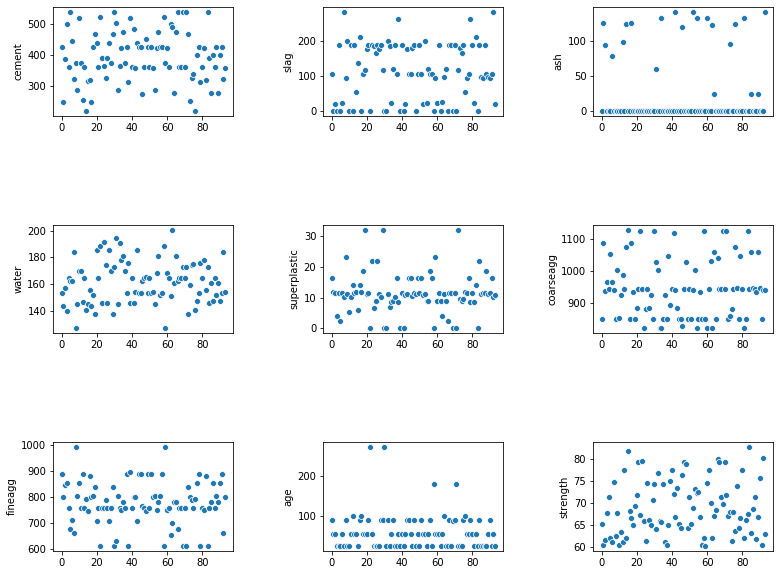

In [28]:
k=1
plt.figure(figsize=(10,10))
for features in d.columns:
    plt.subplot(3,3,k)
    sns.scatterplot(x=np.array(range(0,highstrengthmix.shape[0])),y=highstrengthmix[features])
    plt.subplots_adjust(left=0,right=1,wspace=0.5,hspace=1)

    k=k+1

In [0]:
d1=d.copy()
d1['high']=(d['strength']>=60)
d1.replace({True:3,False:0},inplace=True)
d1["high"]=d1["high"].astype('int')
d1['low']=(d['strength']<=20)
d1.replace({True:2,False:0},inplace=True)
d1["low"]=d1["low"].astype('int')
d1['stren']=d1['high']+d1['low']
d1['ind']=np.array(range(0,d1.shape[0]))



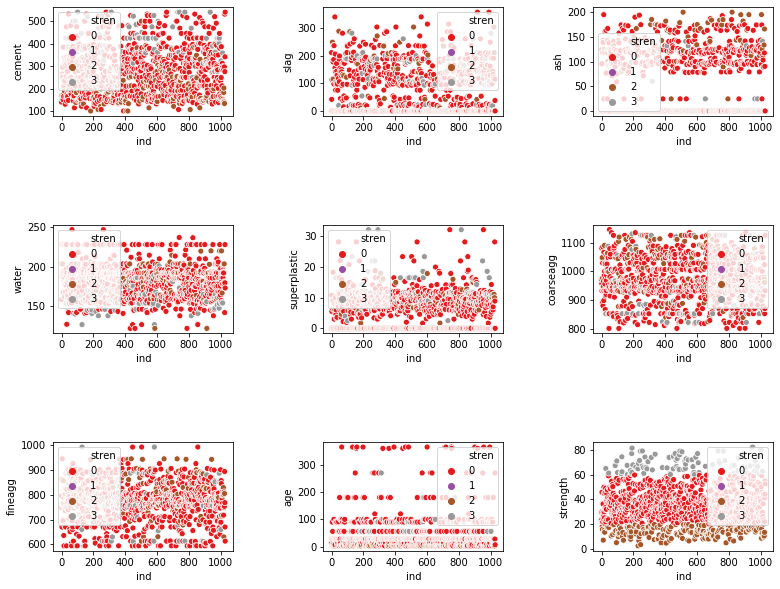

In [30]:
k=1
plt.figure(figsize=(10,10))
for features in d.columns:
    plt.subplot(3,3,k)
    sns.scatterplot(x="ind",y=features,hue='stren',data=d1,palette="Set1")
    plt.subplots_adjust(left=0,right=1,wspace=0.5,hspace=1)
    k=k+1

In [31]:
highstrengthmix[highstrengthmix['cement']<300]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
41,246.8,0.0,125.1,143.3,12.0,1086.8,800.9,56,60.32
161,286.3,200.9,0.0,144.7,11.2,1004.6,803.7,28,67.70
188,252.3,0.0,98.8,146.3,14.2,987.8,889.0,100,60.95
191,218.2,54.6,123.8,140.8,11.9,1075.7,792.7,56,61.99
216,246.8,0.0,125.1,143.3,12.0,1086.8,800.9,100,66.42
337,286.3,200.9,0.0,144.7,11.2,1004.6,803.7,91,76.80
491,275.0,180.0,120.0,162.0,10.4,830.0,765.0,28,76.24
532,286.3,200.9,0.0,144.7,11.2,1004.6,803.7,56,72.99
653,277.2,97.8,24.5,160.7,11.2,1061.7,782.5,100,66.95
824,250.0,180.0,95.0,159.0,9.5,860.0,800.0,28,67.87


The strength is high even is the cement content is below 300 if super plastic is present. slag is present and and aging is high

In [33]:
display((highstrengthmix[highstrengthmix['slag']==0]).describe())
display((lowstrengthmix[lowstrengthmix['slag']==0]).describe())

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,18.000000,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,473.272222,0.0,22.722222,163.327778,4.038889,1052.022222,719.711111,84.777778,68.269444
std,106.024979,0.0,45.612222,17.380070,5.203182,82.306712,108.588570,84.123547,6.152760
min,246.800000,0.0,0.000000,140.000000,0.000000,855.000000,613.000000,28.000000,60.280000
25%,488.750000,0.0,0.000000,146.075000,0.000000,1030.000000,613.000000,28.000000,62.445000
50%,521.000000,0.0,0.000000,163.500000,1.250000,1070.900000,676.000000,28.000000,67.440000
75%,540.000000,0.0,0.000000,173.000000,8.050000,1125.000000,800.900000,100.000000,71.897500
max,540.000000,0.0,125.100000,195.000000,14.200000,1125.000000,896.000000,270.000000,79.990000


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,120.000000,120.0,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,242.570833,0.0,68.928333,183.873333,4.597500,1010.840833,812.015000,12.183333,14.055667
std,75.343792,0.0,75.016296,13.388385,5.482585,77.582809,57.338873,11.065112,3.183094
min,134.700000,0.0,0.000000,154.600000,0.000000,824.000000,613.000000,1.000000,6.270000
25%,165.825000,0.0,0.000000,180.150000,0.000000,967.775000,778.325000,3.000000,12.032500
50%,238.000000,0.0,0.000000,186.000000,0.000000,1009.900000,806.450000,7.000000,14.010000
75%,296.000000,0.0,136.700000,192.000000,9.100000,1075.925000,847.750000,28.000000,16.265000
max,500.000000,0.0,200.100000,220.000000,18.000000,1125.000000,945.000000,28.000000,19.930000


The major reason for strength with slag equal to zero seems to be cement,age and ash content and some superplastic

BASED ON EDA IT SEEMS LIKE SIMPLE LINERA MODEL WILL NOT DO THE TRICK. WE NEED DECISION TREES OR ENSEMBLE TECHNIQUES TO OPT MODEL FOR DIFFERENT SCENARIOS

# Lets try building models

In [0]:
X_train,X_test,y_train,y_test=train_test_split(d.iloc[:,:-1],d.iloc[:,-1],test_size=0.25,random_state=1)

In [0]:
cv = KFold(10, random_state = 1)
consolidate=pd.DataFrame({})

#Creating a Function to append the cross validation scores of the algorithms
def trialscore(data,names, models, x, y):
    Model = []
    RMSE = []
    R_sq = []
    RMSE_std=[]
    R_sq_std=[]
    AR_sq=[]
    AR_sq_std=[]
    for name, model in zip(names, models):
        Model.append(name)
        mean_squared_error=(-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error')
        RMSE.append(np.sqrt(mean_squared_error.mean()))
        RMSE_std.append(mean_squared_error.std())
        R_sq_val=cross_val_score(model, x, y, cv=cv, scoring='r2')
        AR_sq_val=1-((1-R_sq_val.mean())*((x.shape[0])-1))/((x.shape[0])-x.shape[1]-1)
        R_sq.append(R_sq_val.mean())
        R_sq_std.append(R_sq_val.std())
        AR_sq.append(AR_sq_val)
        consolidate=pd.DataFrame({'Data':data,'Model': Model,
                              'RMSE': RMSE,
                              'RMSE std':RMSE_std,
                              'R Squared': R_sq,
                              'R Squared std':R_sq_std,
                              'Adjusted R Squared': AR_sq})
    return consolidate

In [0]:
def trialscore1(data,names, models, x, y):
    Model = []
    RMSE = []
    R_sq = []
    RMSE_std=[]
    R_sq_std=[]
    AR_sq=[]
    AR_sq_std=[]
    for name, model in zip(names, models):
        Model.append(name)
        mean_squared_error=(-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error')
        RMSE.append(np.sqrt(mean_squared_error.mean()))
        RMSE_std.append(mean_squared_error.std())
        R_sq_val=cross_val_score(model, x, y, cv=cv, scoring='r2')
        AR_sq_val=1-((1-R_sq_val.mean())*((x.shape[0])-1))/((x.shape[0])-x.shape[1]-1)
        R_sq.append(R_sq_val.mean())
        R_sq_std.append(R_sq_val.std())
        AR_sq.append(AR_sq_val)
        consolidate=pd.DataFrame({'Data':data,'Model': Model,
                              'RMSE': RMSE,
                              'RMSE std':RMSE_std,
                              'R Squared': R_sq,
                              'R Squared std':R_sq_std,
                              'Adjusted R Squared': AR_sq})
    return consolidate,model

In [0]:
names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'support vector Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','Bagging Regressor','XGboost']
models = [LinearRegression(), Ridge(), Lasso(),
          SVR(), DecisionTreeRegressor(random_state=1),
          RandomForestRegressor(random_state=1), GradientBoostingRegressor(random_state=1), 
          AdaBoostRegressor(random_state=1),BaggingRegressor(random_state=1),XGBRegressor(random_state=1,objective='reg:squarederror')]


# Training on original data

In [38]:
X=X_train
Y=y_train
data='Qriginal'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Qriginal,Linear Regression,10.441723,20.794010,0.592613,0.075036,0.588342
1,Qriginal,Ridge Regression,10.441722,20.794104,0.592613,0.075036,0.588342
2,Qriginal,Lasso Regression,10.445168,20.881107,0.592382,0.075193,0.588108
3,Qriginal,support vector Regressor,16.332026,36.171499,0.008948,0.015386,-0.001444
4,Qriginal,Decision Tree Regressor,6.513551,10.522258,0.839503,0.045887,0.837820
5,Qriginal,Random Forest Regressor,5.338190,6.962386,0.893104,0.027570,0.891983
6,Qriginal,Gradient Boosting Regressor,5.267157,5.859239,0.896597,0.020008,0.895513
7,Qriginal,Adaboost Regressor,7.648870,8.158315,0.781805,0.021140,0.779518
8,Qriginal,Bagging Regressor,5.403018,7.090160,0.890436,0.028055,0.889288
9,Qriginal,XGboost,5.320619,5.498294,0.894380,0.018417,0.893273


# Training on scaled data

In [39]:
X=X_train.apply(zscore)
Y=y_train
data='scaled_data'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,scaled_data,Linear Regression,10.441723,20.794010,0.592613,0.075036,0.588342
1,scaled_data,Ridge Regression,10.441692,20.624463,0.592671,0.073954,0.588400
2,scaled_data,Lasso Regression,10.982516,18.745346,0.551342,0.042442,0.546637
3,scaled_data,support vector Regressor,10.292923,19.156383,0.606367,0.048175,0.602240
4,scaled_data,Decision Tree Regressor,6.507612,10.294763,0.839820,0.044939,0.838140
5,scaled_data,Random Forest Regressor,5.337980,6.915096,0.893127,0.027326,0.892006
6,scaled_data,Gradient Boosting Regressor,5.264058,5.856326,0.896702,0.020073,0.895619
7,scaled_data,Adaboost Regressor,7.570896,8.111056,0.786196,0.022070,0.783954
8,scaled_data,Bagging Regressor,5.400349,7.035619,0.890554,0.027818,0.889407
9,scaled_data,XGboost,5.320619,5.498294,0.894380,0.018417,0.893273


As known the performance of linear model did notchange with scaling

for Lasso RMSE gone down and R squared gone up.

SVM, r2 value went up by considerable amount

Gradient boosting regressor has slight increase in R2 value

In [40]:
scaler=MinMaxScaler()
X=scaler.fit_transform(X_train)
Y=y_train
data='scaled_data'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,scaled_data,Linear Regression,10.441723,20.794010,0.592613,0.075036,0.588342
1,scaled_data,Ridge Regression,10.490231,19.219267,0.589481,0.063170,0.585176
2,scaled_data,Lasso Regression,14.765781,33.561347,0.191561,0.029408,0.183084
3,scaled_data,support vector Regressor,14.079140,30.019106,0.264758,0.023662,0.257049
4,scaled_data,Decision Tree Regressor,6.514563,10.509392,0.839461,0.045834,0.837777
5,scaled_data,Random Forest Regressor,5.332530,6.976539,0.893350,0.027539,0.892232
6,scaled_data,Gradient Boosting Regressor,5.264079,5.856422,0.896702,0.020074,0.895618
7,scaled_data,Adaboost Regressor,7.635026,8.190715,0.782900,0.018156,0.780623
8,scaled_data,Bagging Regressor,5.396101,7.101091,0.890723,0.028081,0.889577
9,scaled_data,XGboost,5.320222,5.494323,0.894397,0.018390,0.893290


no change in gradient boosting r2 value

# Training on Polynomial data

In [41]:
poly=PolynomialFeatures(degree=2,interaction_only=True)
X = poly.fit_transform(X_train)
X=(X-X.mean())/X.std()
Y=y_train
data='2degreepolynomial'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,2degreepolynomial,Linear Regression,8.791777,14.593358,0.712599,0.037111,0.698112
1,2degreepolynomial,Ridge Regression,10.042526,24.366488,0.625840,0.073365,0.606979
2,2degreepolynomial,Lasso Regression,13.011650,25.376974,0.371059,0.038388,0.339355
3,2degreepolynomial,support vector Regressor,13.550415,29.022121,0.319460,0.029125,0.285154
4,2degreepolynomial,Decision Tree Regressor,6.952564,9.697312,0.815263,0.051731,0.805951
5,2degreepolynomial,Random Forest Regressor,5.430686,8.303351,0.889360,0.032230,0.883782
6,2degreepolynomial,Gradient Boosting Regressor,4.983525,4.590176,0.906905,0.017420,0.902212
7,2degreepolynomial,Adaboost Regressor,6.910849,8.092872,0.821257,0.028509,0.812246
8,2degreepolynomial,Bagging Regressor,5.430411,8.488181,0.889092,0.034105,0.883502
9,2degreepolynomial,XGboost,4.964476,3.758394,0.907662,0.014162,0.903007


The r2 score and adjusted r2 went up for ridge, gradient and XG boost but went down for Lasso model. shows potential problem over fitting

In [42]:
poly=PolynomialFeatures(degree=3,interaction_only=True)
X = poly.fit_transform(X_train)
X=(X-X.mean())/X.std()
Y=y_train
data='3degreepolynomial'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,3degreepolynomial,Linear Regression,8.747674,20.864208,0.715192,0.064489,0.676126
1,3degreepolynomial,Ridge Regression,9.247824,20.981904,0.683031,0.057532,0.639553
2,3degreepolynomial,Lasso Regression,10.634043,20.633561,0.580124,0.050730,0.522530
3,3degreepolynomial,support vector Regressor,11.263494,17.926379,0.528191,0.030659,0.463474
4,3degreepolynomial,Decision Tree Regressor,6.760786,8.600892,0.826223,0.044443,0.802387
5,3degreepolynomial,Random Forest Regressor,5.306775,5.135786,0.893606,0.023677,0.879012
6,3degreepolynomial,Gradient Boosting Regressor,4.965868,3.675890,0.907179,0.016118,0.894447
7,3degreepolynomial,Adaboost Regressor,6.959926,9.037797,0.819419,0.027384,0.794649
8,3degreepolynomial,Bagging Regressor,5.382844,5.854253,0.890638,0.025365,0.875637
9,3degreepolynomial,XGboost,5.075460,4.239781,0.903103,0.017687,0.889812


The r value went up for gradient boosting but it is just due to increase in number of features,the Adjusted r2 went down. but the thing to note here is that the std for RMSE for thid model came down

# Applying Square root

In [43]:
X=X_train.apply(np.sqrt)
X=X.apply(zscore)
Y=y_train
data='scaled_data'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,scaled_data,Linear Regression,8.557712,13.768623,0.727623,0.040406,0.724767
1,scaled_data,Ridge Regression,8.557929,13.720134,0.727609,0.040157,0.724753
2,scaled_data,Lasso Regression,8.972544,14.366297,0.701607,0.029797,0.698479
3,scaled_data,support vector Regressor,8.440372,11.249362,0.735358,0.023179,0.732583
4,scaled_data,Decision Tree Regressor,6.516113,10.530871,0.839296,0.045963,0.837611
5,scaled_data,Random Forest Regressor,5.342627,7.026409,0.892983,0.027529,0.891861
6,scaled_data,Gradient Boosting Regressor,5.259018,5.784429,0.896916,0.019637,0.895835
7,scaled_data,Adaboost Regressor,7.542301,7.367698,0.787384,0.022455,0.785155
8,scaled_data,Bagging Regressor,5.395392,7.113280,0.890800,0.027896,0.889655
9,scaled_data,XGboost,5.319198,5.489349,0.894443,0.018323,0.893337


This increase the accuracy slightly and reduces std

# Let remove duplicate data

In [45]:
X_traind,X_testd,y_traind,y_testd=train_test_split(d_noduplicate.iloc[:,:-1],d_noduplicate.iloc[:,-1],test_size=0.25,random_state=1)
X=X_traind
Y=y_traind
data='noduplicate_data'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,noduplicate_data,Linear Regression,10.361316,19.291980,0.603587,0.081978,0.599325
1,noduplicate_data,Ridge Regression,10.361313,19.291950,0.603588,0.081977,0.599325
2,noduplicate_data,Lasso Regression,10.363921,19.232510,0.603497,0.081408,0.599234
3,noduplicate_data,support vector Regressor,16.509079,32.788096,0.005992,0.016326,-0.004696
4,noduplicate_data,Decision Tree Regressor,7.894429,29.344640,0.773603,0.094882,0.771169
5,noduplicate_data,Random Forest Regressor,5.737343,13.336647,0.882174,0.038494,0.880907
6,noduplicate_data,Gradient Boosting Regressor,5.430071,8.596149,0.892776,0.027948,0.891623
7,noduplicate_data,Adaboost Regressor,7.855598,13.099913,0.775342,0.036797,0.772926
8,noduplicate_data,Bagging Regressor,5.862014,14.704373,0.877519,0.041961,0.876202
9,noduplicate_data,XGboost,5.352938,9.144470,0.895991,0.030303,0.894873


Seems no use

# Lets apply PCA

In [46]:
pca=PCA(n_components=8)
X=(X_train-X_train.mean())/X_train.std()
X=pca.fit_transform(X)
Y=y_train
data='PCAData'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,PCAData,Linear Regression,10.441723,20.794010,0.592613,0.075036,0.588342
1,PCAData,Ridge Regression,10.441693,20.624255,0.592671,0.073952,0.588400
2,PCAData,Lasso Regression,11.120652,19.829253,0.540028,0.046031,0.535205
3,PCAData,support vector Regressor,10.291891,19.152682,0.606445,0.048174,0.602319
4,PCAData,Decision Tree Regressor,9.772632,21.250659,0.631413,0.120735,0.627548
5,PCAData,Random Forest Regressor,7.994114,16.304874,0.756060,0.080992,0.753502
6,PCAData,Gradient Boosting Regressor,7.918005,9.653763,0.763194,0.049907,0.760711
7,PCAData,Adaboost Regressor,9.766400,14.454587,0.643671,0.044771,0.639935
8,PCAData,Bagging Regressor,7.931181,15.398642,0.760417,0.075828,0.757905
9,PCAData,XGboost,7.910680,9.955542,0.764208,0.047371,0.761736


As Expected PCA doesnot do any good. as there are already no correlation between the attributes. PCA do us no good

# Clustering 

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

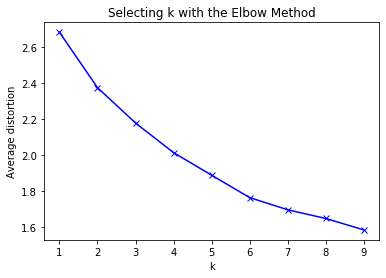

In [47]:
from scipy.spatial.distance import cdist
d_scaled=X_train.apply(zscore)
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(d_scaled)
    prediction=model.predict(d_scaled)
    meanDistortions.append(sum(np.min(cdist(d_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / d_scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

There is no definite elbow but seems like slight elbow is present at 6. so there could be six clusters. but lets check the performance for all cluster

In [48]:
r2_avg1=[]
for n in range(1,7):
    d_scaled=X_train.apply(zscore)
    k=KMeans(n_clusters=n)
    k.fit(d_scaled)
    d_scaled['group']=k.predict(d_scaled)
    d_scaled['y']=y_train
    r2_avg=0
    avg=0
    for i in range(0,n):
        m=d_scaled[d_scaled['group']==i].drop(['group'],axis=1)
        X=m.iloc[:,:-1]
        Y=m.iloc[:,-1]
        data='cluster'+str(i+1)+'of'+str(n)
        consolidate=trialscore(data,names, models, X,Y)
        display(consolidate)
        r2_avg=r2_avg+(consolidate.iloc[6,4])/n
    r2_avg1.append(r2_avg)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster1of1,Linear Regression,10.441723,20.794010,0.592613,0.075036,0.588342
1,cluster1of1,Ridge Regression,10.441692,20.624463,0.592671,0.073954,0.588400
2,cluster1of1,Lasso Regression,10.982516,18.745346,0.551342,0.042442,0.546637
3,cluster1of1,support vector Regressor,10.292923,19.156383,0.606367,0.048175,0.602240
4,cluster1of1,Decision Tree Regressor,6.507612,10.294763,0.839820,0.044939,0.838140
5,cluster1of1,Random Forest Regressor,5.337980,6.915096,0.893127,0.027326,0.892006
6,cluster1of1,Gradient Boosting Regressor,5.264058,5.856326,0.896702,0.020073,0.895619
7,cluster1of1,Adaboost Regressor,7.570896,8.111056,0.786196,0.022070,0.783954
8,cluster1of1,Bagging Regressor,5.400349,7.035619,0.890554,0.027818,0.889407
9,cluster1of1,XGboost,5.320619,5.498294,0.894380,0.018417,0.893273


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster1of2,Linear Regression,10.608844,26.002805,0.617989,0.112851,0.609661
1,cluster1of2,Ridge Regression,10.602024,25.865051,0.618662,0.111834,0.610350
2,cluster1of2,Lasso Regression,10.950622,23.717709,0.596924,0.094189,0.588138
3,cluster1of2,support vector Regressor,11.317233,23.346777,0.574707,0.062185,0.565436
4,cluster1of2,Decision Tree Regressor,7.801101,27.252767,0.794118,0.093422,0.789630
5,cluster1of2,Random Forest Regressor,5.978286,13.621676,0.880559,0.044270,0.877955
6,cluster1of2,Gradient Boosting Regressor,5.241537,10.927722,0.906664,0.041761,0.904629
7,cluster1of2,Adaboost Regressor,7.610209,12.470705,0.803841,0.052000,0.799565
8,cluster1of2,Bagging Regressor,5.896624,13.328201,0.883600,0.043994,0.881063
9,cluster1of2,XGboost,5.266239,11.507234,0.906320,0.041857,0.904278


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster2of2,Linear Regression,7.484358,12.091168,0.740225,0.097375,0.734855
1,cluster2of2,Ridge Regression,7.489334,12.142765,0.739135,0.101434,0.733742
2,cluster2of2,Lasso Regression,8.237333,15.945134,0.690329,0.099809,0.683928
3,cluster2of2,support vector Regressor,10.598286,28.669566,0.504489,0.080026,0.494245
4,cluster2of2,Decision Tree Regressor,6.235595,9.720907,0.824621,0.046479,0.820996
5,cluster2of2,Random Forest Regressor,5.510928,10.738915,0.863974,0.046791,0.861162
6,cluster2of2,Gradient Boosting Regressor,4.491610,3.759438,0.907288,0.029745,0.905372
7,cluster2of2,Adaboost Regressor,6.588495,9.258383,0.799776,0.070569,0.795637
8,cluster2of2,Bagging Regressor,5.574936,10.771404,0.862118,0.041576,0.859268
9,cluster2of2,XGboost,4.372134,3.415823,0.910889,0.033193,0.909047


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster1of3,Linear Regression,8.599636,29.938327,0.757507,0.072335,0.749490
1,cluster1of3,Ridge Regression,8.586213,29.215274,0.758355,0.069884,0.750366
2,cluster1of3,Lasso Regression,9.211341,27.237880,0.723385,0.054755,0.714240
3,cluster1of3,support vector Regressor,12.274782,37.352986,0.506610,0.053650,0.490300
4,cluster1of3,Decision Tree Regressor,7.716161,18.091690,0.786247,0.102180,0.779181
5,cluster1of3,Random Forest Regressor,6.582402,18.256521,0.850669,0.070206,0.845732
6,cluster1of3,Gradient Boosting Regressor,5.544681,19.010613,0.895100,0.064058,0.891633
7,cluster1of3,Adaboost Regressor,7.367291,13.618989,0.814965,0.057118,0.808848
8,cluster1of3,Bagging Regressor,6.698098,17.122195,0.846277,0.065559,0.841195
9,cluster1of3,XGboost,5.564329,19.920082,0.894958,0.065126,0.891485


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster2of3,Linear Regression,9.391118,18.283919,0.604905,0.126287,0.587912
1,cluster2of3,Ridge Regression,9.373535,17.517813,0.607345,0.120537,0.590457
2,cluster2of3,Lasso Regression,10.514575,26.872262,0.521488,0.112217,0.500907
3,cluster2of3,support vector Regressor,10.912981,27.298253,0.490590,0.095679,0.468680
4,cluster2of3,Decision Tree Regressor,6.853740,36.029226,0.791427,0.177984,0.782456
5,cluster2of3,Random Forest Regressor,5.245672,16.277362,0.884317,0.056395,0.879341
6,cluster2of3,Gradient Boosting Regressor,4.239477,10.624354,0.926246,0.033388,0.923074
7,cluster2of3,Adaboost Regressor,6.749247,18.439097,0.805324,0.068580,0.796951
8,cluster2of3,Bagging Regressor,5.268296,15.782638,0.883127,0.061417,0.878100
9,cluster2of3,XGboost,4.153706,8.047647,0.928335,0.026463,0.925253


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster3of3,Linear Regression,7.638345,13.606714,0.743290,0.097045,0.736811
1,cluster3of3,Ridge Regression,7.653082,13.427606,0.742066,0.098326,0.735557
2,cluster3of3,Lasso Regression,8.441027,17.772687,0.694415,0.091347,0.686703
3,cluster3of3,support vector Regressor,11.045927,31.649229,0.495188,0.059849,0.482448
4,cluster3of3,Decision Tree Regressor,7.338160,12.690550,0.765741,0.082307,0.759829
5,cluster3of3,Random Forest Regressor,5.791939,12.490888,0.858059,0.047805,0.854477
6,cluster3of3,Gradient Boosting Regressor,4.409415,4.838827,0.916849,0.024653,0.914750
7,cluster3of3,Adaboost Regressor,6.586126,9.834886,0.808150,0.077922,0.803308
8,cluster3of3,Bagging Regressor,5.904003,13.909586,0.850508,0.062426,0.846735
9,cluster3of3,XGboost,4.508901,4.204873,0.910875,0.033584,0.908626


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster1of4,Linear Regression,11.233965,37.754145,0.327234,0.178040,0.283477
1,cluster1of4,Ridge Regression,11.177880,37.911519,0.339131,0.161165,0.296147
2,cluster1of4,Lasso Regression,11.388094,54.841883,0.356391,0.126902,0.314530
3,cluster1of4,support vector Regressor,13.856736,70.856782,0.043192,0.195795,-0.019040
4,cluster1of4,Decision Tree Regressor,8.707384,52.639881,0.613903,0.260704,0.588791
5,cluster1of4,Random Forest Regressor,7.936848,36.050279,0.677545,0.216083,0.656572
6,cluster1of4,Gradient Boosting Regressor,7.014562,31.642515,0.729294,0.215948,0.711687
7,cluster1of4,Adaboost Regressor,8.937346,27.994462,0.568599,0.197359,0.540541
8,cluster1of4,Bagging Regressor,7.743132,32.740513,0.694585,0.189383,0.674721
9,cluster1of4,XGboost,7.035400,25.976936,0.739963,0.126095,0.723050


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster2of4,Linear Regression,8.098798,34.701663,0.597374,0.237182,0.580332
1,cluster2of4,Ridge Regression,8.065806,32.905679,0.601367,0.224208,0.584494
2,cluster2of4,Lasso Regression,8.732374,30.228972,0.564802,0.100904,0.546381
3,cluster2of4,support vector Regressor,11.068480,51.934322,0.322841,0.069077,0.294178
4,cluster2of4,Decision Tree Regressor,6.921826,24.652682,0.716622,0.125951,0.704627
5,cluster2of4,Random Forest Regressor,5.729412,15.517859,0.810646,0.074642,0.802631
6,cluster2of4,Gradient Boosting Regressor,4.353737,8.602142,0.883536,0.063239,0.878606
7,cluster2of4,Adaboost Regressor,6.451050,15.526474,0.748552,0.114150,0.737909
8,cluster2of4,Bagging Regressor,5.821998,16.590074,0.800679,0.090853,0.792243
9,cluster2of4,XGboost,4.587516,7.021807,0.874416,0.049832,0.869100


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster3of4,Linear Regression,6.461989,12.842248,0.728719,0.101112,0.719861
1,cluster3of4,Ridge Regression,6.485690,12.713597,0.724848,0.106423,0.715864
2,cluster3of4,Lasso Regression,8.224180,13.719998,0.566625,0.107163,0.552474
3,cluster3of4,support vector Regressor,9.858826,14.496094,0.384384,0.077359,0.364283
4,cluster3of4,Decision Tree Regressor,6.654072,16.555334,0.711869,0.124746,0.702461
5,cluster3of4,Random Forest Regressor,5.116573,9.278945,0.838474,0.035935,0.833199
6,cluster3of4,Gradient Boosting Regressor,4.097569,7.642149,0.897586,0.029845,0.894242
7,cluster3of4,Adaboost Regressor,5.800705,9.751025,0.786785,0.059431,0.779823
8,cluster3of4,Bagging Regressor,5.177829,9.114226,0.833042,0.041763,0.827590
9,cluster3of4,XGboost,4.008274,6.009073,0.901322,0.023350,0.898100


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster4of4,Linear Regression,9.420054,16.289538,0.535905,0.173545,0.515163
1,cluster4of4,Ridge Regression,9.375473,16.135503,0.542351,0.164050,0.521898
2,cluster4of4,Lasso Regression,9.839376,22.156677,0.512368,0.128020,0.490575
3,cluster4of4,support vector Regressor,10.091699,24.572317,0.504674,0.071587,0.482536
4,cluster4of4,Decision Tree Regressor,6.320945,16.687521,0.796554,0.102621,0.787462
5,cluster4of4,Random Forest Regressor,5.386943,20.698623,0.857632,0.083851,0.851269
6,cluster4of4,Gradient Boosting Regressor,4.391658,15.908575,0.903915,0.072045,0.899620
7,cluster4of4,Adaboost Regressor,6.283255,16.099649,0.797048,0.087756,0.787978
8,cluster4of4,Bagging Regressor,5.464985,23.475956,0.853344,0.095469,0.846789
9,cluster4of4,XGboost,4.558800,19.809757,0.900064,0.082365,0.895598


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster1of5,Linear Regression,7.809530,37.596935,0.065960,0.605985,-0.141604
1,cluster1of5,Ridge Regression,7.770401,45.042510,0.085061,0.745217,-0.118258
2,cluster1of5,Lasso Regression,7.669037,44.844124,0.186336,0.495167,0.005522
3,cluster1of5,support vector Regressor,9.042279,72.649931,0.023571,0.380668,-0.193413
4,cluster1of5,Decision Tree Regressor,4.698632,40.980152,0.704938,0.548626,0.639368
5,cluster1of5,Random Forest Regressor,3.837489,18.326683,0.828202,0.224149,0.790024
6,cluster1of5,Gradient Boosting Regressor,2.794323,6.312565,0.899016,0.070500,0.876575
7,cluster1of5,Adaboost Regressor,2.990399,7.603128,0.886262,0.081434,0.860987
8,cluster1of5,Bagging Regressor,3.714680,19.966966,0.834898,0.253662,0.798208
9,cluster1of5,XGboost,2.461482,6.091474,0.931111,0.052490,0.915803


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster2of5,Linear Regression,6.976786,17.133764,0.684803,0.200446,0.671390
1,cluster2of5,Ridge Regression,6.981002,16.658722,0.686364,0.193245,0.673018
2,cluster2of5,Lasso Regression,8.136538,23.254320,0.618079,0.102806,0.601827
3,cluster2of5,support vector Regressor,11.110551,49.348976,0.317503,0.068377,0.288461
4,cluster2of5,Decision Tree Regressor,6.909069,21.742880,0.714048,0.127307,0.701879
5,cluster2of5,Random Forest Regressor,5.718537,16.215805,0.804197,0.105395,0.795865
6,cluster2of5,Gradient Boosting Regressor,4.581537,10.002005,0.869173,0.078877,0.863606
7,cluster2of5,Adaboost Regressor,6.281983,14.201229,0.764109,0.108417,0.754071
8,cluster2of5,Bagging Regressor,5.647736,16.340203,0.813534,0.094184,0.805600
9,cluster2of5,XGboost,4.472735,7.638304,0.875069,0.068347,0.869753


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster3of5,Linear Regression,7.135243,15.840629,0.728534,0.127100,0.712566
1,cluster3of5,Ridge Regression,7.106892,15.448267,0.730883,0.125862,0.715053
2,cluster3of5,Lasso Regression,8.316830,19.793218,0.646980,0.126616,0.626214
3,cluster3of5,support vector Regressor,10.685673,35.012829,0.445115,0.090431,0.412475
4,cluster3of5,Decision Tree Regressor,6.804122,28.179910,0.751959,0.170274,0.737368
5,cluster3of5,Random Forest Regressor,5.730253,22.106507,0.838058,0.095623,0.828532
6,cluster3of5,Gradient Boosting Regressor,5.041741,16.022586,0.869663,0.074030,0.861996
7,cluster3of5,Adaboost Regressor,6.416440,14.295479,0.781438,0.108877,0.768581
8,cluster3of5,Bagging Regressor,5.698304,21.015672,0.838443,0.092064,0.828940
9,cluster3of5,XGboost,4.713370,16.955766,0.884956,0.083225,0.878189


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster4of5,Linear Regression,11.310007,38.860671,0.347731,0.143986,0.304960
1,cluster4of5,Ridge Regression,11.254812,38.623890,0.358272,0.127412,0.316192
2,cluster4of5,Lasso Regression,11.496342,53.301789,0.366707,0.103444,0.325180
3,cluster4of5,support vector Regressor,13.928872,70.052706,0.068067,0.119925,0.006956
4,cluster4of5,Decision Tree Regressor,8.670809,48.223101,0.640650,0.205802,0.617086
5,cluster4of5,Random Forest Regressor,7.301691,29.280687,0.750346,0.077843,0.733976
6,cluster4of5,Gradient Boosting Regressor,7.057641,27.912397,0.756839,0.119553,0.740894
7,cluster4of5,Adaboost Regressor,8.417415,26.065094,0.642776,0.121227,0.619351
8,cluster4of5,Bagging Regressor,7.462022,25.359415,0.729893,0.095528,0.712181
9,cluster4of5,XGboost,7.051003,24.523831,0.756559,0.084179,0.740596


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster5of5,Linear Regression,6.461989,12.842248,0.728719,0.101112,0.719861
1,cluster5of5,Ridge Regression,6.485690,12.713597,0.724848,0.106423,0.715864
2,cluster5of5,Lasso Regression,8.224180,13.719998,0.566625,0.107163,0.552474
3,cluster5of5,support vector Regressor,9.858826,14.496094,0.384384,0.077359,0.364283
4,cluster5of5,Decision Tree Regressor,6.654072,16.555334,0.711869,0.124746,0.702461
5,cluster5of5,Random Forest Regressor,5.116573,9.278945,0.838474,0.035935,0.833199
6,cluster5of5,Gradient Boosting Regressor,4.097569,7.642149,0.897586,0.029845,0.894242
7,cluster5of5,Adaboost Regressor,5.800705,9.751025,0.786785,0.059431,0.779823
8,cluster5of5,Bagging Regressor,5.177829,9.114226,0.833042,0.041763,0.827590
9,cluster5of5,XGboost,4.008274,6.009073,0.901322,0.023350,0.898100


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster1of6,Linear Regression,10.829501,34.522754,0.433462,0.120683,0.391496
1,cluster1of6,Ridge Regression,10.774267,35.335314,0.442752,0.112027,0.401475
2,cluster1of6,Lasso Regression,11.286417,51.509882,0.419589,0.106729,0.376595
3,cluster1of6,support vector Regressor,14.027812,68.885200,0.098799,0.087463,0.032043
4,cluster1of6,Decision Tree Regressor,9.018162,38.356324,0.617887,0.139640,0.589583
5,cluster1of6,Random Forest Regressor,7.942109,36.552680,0.714919,0.121267,0.693802
6,cluster1of6,Gradient Boosting Regressor,7.454451,36.415967,0.745592,0.111573,0.726747
7,cluster1of6,Adaboost Regressor,8.670559,37.830865,0.651783,0.125252,0.625989
8,cluster1of6,Bagging Regressor,8.096500,41.856240,0.705323,0.133127,0.683495
9,cluster1of6,XGboost,7.494198,37.935985,0.737848,0.122909,0.718429


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster2of6,Linear Regression,7.887459,30.568093,0.660406,0.208557,0.638672
1,cluster2of6,Ridge Regression,7.827655,29.772549,0.665434,0.207940,0.644022
2,cluster2of6,Lasso Regression,8.477724,29.603954,0.636893,0.157465,0.613654
3,cluster2of6,support vector Regressor,12.730911,55.029731,0.198533,0.270838,0.147239
4,cluster2of6,Decision Tree Regressor,7.151334,30.227647,0.718160,0.251966,0.700122
5,cluster2of6,Random Forest Regressor,6.284802,15.653887,0.786986,0.127356,0.773353
6,cluster2of6,Gradient Boosting Regressor,4.566273,11.614738,0.897267,0.057408,0.890692
7,cluster2of6,Adaboost Regressor,6.670856,19.710249,0.767633,0.125959,0.752762
8,cluster2of6,Bagging Regressor,6.544735,18.133549,0.762527,0.155890,0.747329
9,cluster2of6,XGboost,4.601372,9.448649,0.895919,0.041341,0.889258


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster3of6,Linear Regression,7.748060,38.025119,0.083869,0.591192,-0.125533
1,cluster3of6,Ridge Regression,7.760204,44.756086,0.078403,0.735397,-0.132247
2,cluster3of6,Lasso Regression,7.644496,44.110199,0.175003,0.526608,-0.013567
3,cluster3of6,support vector Regressor,9.068346,72.378365,0.008328,0.394526,-0.218340
4,cluster3of6,Decision Tree Regressor,3.172100,8.052000,0.864349,0.101470,0.833343
5,cluster3of6,Random Forest Regressor,3.538548,11.208216,0.838760,0.150154,0.801906
6,cluster3of6,Gradient Boosting Regressor,2.737967,6.391398,0.902383,0.073036,0.880071
7,cluster3of6,Adaboost Regressor,3.040930,7.596797,0.875064,0.099824,0.846507
8,cluster3of6,Bagging Regressor,3.515021,11.503406,0.851378,0.136489,0.817408
9,cluster3of6,XGboost,2.479545,5.683627,0.925013,0.053403,0.907873


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster4of6,Linear Regression,7.102238,14.617310,0.716623,0.095612,0.699317
1,cluster4of6,Ridge Regression,7.045313,16.370286,0.731970,0.066655,0.715602
2,cluster4of6,Lasso Regression,8.092365,32.884016,0.690480,0.073817,0.671578
3,cluster4of6,support vector Regressor,10.526479,55.578628,0.466514,0.109171,0.433934
4,cluster4of6,Decision Tree Regressor,7.127636,32.136935,0.733141,0.133633,0.716844
5,cluster4of6,Random Forest Regressor,6.331587,31.082288,0.803998,0.110824,0.792028
6,cluster4of6,Gradient Boosting Regressor,4.952775,18.045064,0.872652,0.069428,0.864875
7,cluster4of6,Adaboost Regressor,6.125046,17.454282,0.808610,0.050395,0.796922
8,cluster4of6,Bagging Regressor,6.302756,29.696402,0.804992,0.108047,0.793083
9,cluster4of6,XGboost,4.714591,18.099230,0.881934,0.071677,0.874724


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster5of6,Linear Regression,5.928129,15.810572,0.732376,0.107696,0.712367
1,cluster5of6,Ridge Regression,6.095138,17.399259,0.697592,0.186977,0.674982
2,cluster5of6,Lasso Regression,8.114999,37.544458,0.475780,0.416229,0.436586
3,cluster5of6,support vector Regressor,10.596115,58.097711,0.255445,0.143536,0.199777
4,cluster5of6,Decision Tree Regressor,7.053301,53.846667,0.627837,0.374642,0.600012
5,cluster5of6,Random Forest Regressor,6.807446,39.576033,0.652254,0.293907,0.626254
6,cluster5of6,Gradient Boosting Regressor,4.539865,18.586252,0.835116,0.161062,0.822788
7,cluster5of6,Adaboost Regressor,6.500616,24.703045,0.661365,0.206228,0.636046
8,cluster5of6,Bagging Regressor,6.359822,37.586093,0.689213,0.286347,0.665977
9,cluster5of6,XGboost,4.613314,20.068513,0.831438,0.157048,0.818835


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,cluster6of6,Linear Regression,6.627160,11.918374,0.729858,0.105399,0.719664
1,cluster6of6,Ridge Regression,6.668965,11.829923,0.725421,0.109382,0.715059
2,cluster6of6,Lasso Regression,8.411317,19.287532,0.575548,0.126427,0.559531
3,cluster6of6,support vector Regressor,10.355505,19.415301,0.365929,0.091504,0.342001
4,cluster6of6,Decision Tree Regressor,6.945069,24.477603,0.714565,0.134699,0.703794
5,cluster6of6,Random Forest Regressor,5.666060,20.734586,0.813535,0.096403,0.806499
6,cluster6of6,Gradient Boosting Regressor,4.138103,10.630576,0.900832,0.048381,0.897090
7,cluster6of6,Adaboost Regressor,5.808096,13.663100,0.798831,0.077343,0.791239
8,cluster6of6,Bagging Regressor,5.658922,17.709464,0.813003,0.086063,0.805946
9,cluster6of6,XGboost,4.005102,9.923850,0.906471,0.045166,0.902941


In [0]:
 r2_avg1

[0.8967024335103355,
 0.9069760515626855,
 0.9127319498687887,
 0.85358251351033,
 0.8584551564027382,
 0.8512282364304193]

# Grouping based on month

In [49]:
d1=d[d['age']<=30]
#X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','ash','slag','water','cement']],d1['strength'],test_size=0.25,random_state=1)
X=d1.iloc[:,:-1]
Y=d1.iloc[:,-1]
data='month1'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,month1,Linear Regression,7.010080,8.832196,0.782478,0.038444,0.780126
1,month1,Ridge Regression,7.010078,8.832363,0.782478,0.038444,0.780127
2,month1,Lasso Regression,7.008750,8.896946,0.782583,0.038694,0.780233
3,month1,support vector Regressor,14.995644,36.487610,0.017976,0.029456,0.007359
4,month1,Decision Tree Regressor,6.711993,17.328834,0.804127,0.066874,0.802010
5,month1,Random Forest Regressor,5.841745,10.445771,0.850514,0.038203,0.848898
6,month1,Gradient Boosting Regressor,5.464714,7.714273,0.868898,0.028192,0.867480
7,month1,Adaboost Regressor,7.737836,9.862048,0.735495,0.042780,0.732635
8,month1,Bagging Regressor,5.769726,10.896980,0.854320,0.039331,0.852745
9,month1,XGboost,5.495443,8.884644,0.867912,0.030609,0.866484


Results are NO good at all, so it is no use in creating custers to improve the model predictions

# Combining binders as one variable

In [0]:
d1=d.copy()
d1['binders']=(d1['cement']+d1['slag']+d1['ash'])/d1['water']

In [0]:
d1.drop(['cement','water','ash','slag'],axis=1,inplace=True)

In [52]:
d1.head()

,superplastic,coarseagg,fineagg,age,strength,binders
0,0.0,971.8,748.5,28,29.89,1.736118
1,10.8,1080.8,796.2,14,23.51,2.118762
2,5.5,956.9,861.2,28,29.22,1.844717
3,0.0,932.0,670.0,28,45.85,1.666667
4,9.1,1047.4,696.7,28,18.29,1.749612


In [0]:
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders']],d1['strength'],test_size=0.25,random_state=1)

In [55]:
X=X_train
Y=y_train
data='Ratio1'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Ratio1,Linear Regression,10.772687,22.998103,0.567200,0.077478,0.564374
1,Ratio1,Ridge Regression,10.772764,22.925841,0.567236,0.076846,0.564412
2,Ratio1,Lasso Regression,10.973547,21.490977,0.552303,0.057198,0.549380
3,Ratio1,support vector Regressor,16.150472,36.441254,0.031354,0.015833,0.025031
4,Ratio1,Decision Tree Regressor,7.161744,15.037300,0.804832,0.067214,0.803558
5,Ratio1,Random Forest Regressor,6.217588,10.209506,0.854209,0.040155,0.853258
6,Ratio1,Gradient Boosting Regressor,5.896070,8.369966,0.869565,0.029370,0.868714
7,Ratio1,Adaboost Regressor,7.729050,11.491004,0.776517,0.036433,0.775059
8,Ratio1,Bagging Regressor,6.199231,11.036468,0.855533,0.040988,0.854590
9,Ratio1,XGboost,5.944208,7.798572,0.867077,0.029041,0.866209


r2 score decreased

In [56]:
d1=d.copy()
d1['binders']=(d1['cement'])/d1['water']
d1.drop(['cement','water'],axis=1,inplace=True)
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','ash','slag']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='Ratio2'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Ratio2,Linear Regression,10.563603,21.074078,0.583711,0.070723,0.579897
1,Ratio2,Ridge Regression,10.563367,20.978796,0.583768,0.070028,0.579955
2,Ratio2,Lasso Regression,10.851792,19.745839,0.561889,0.052420,0.557875
3,Ratio2,support vector Regressor,16.266529,36.734263,0.017282,0.015702,0.008278
4,Ratio2,Decision Tree Regressor,6.484310,5.461169,0.842176,0.022462,0.840730
5,Ratio2,Random Forest Regressor,5.309004,6.904593,0.893844,0.028349,0.892871
6,Ratio2,Gradient Boosting Regressor,5.204897,5.104420,0.898105,0.021010,0.897171
7,Ratio2,Adaboost Regressor,7.698507,9.448316,0.778676,0.028609,0.776648
8,Ratio2,Bagging Regressor,5.280677,6.581861,0.894898,0.027584,0.893935
9,Ratio2,XGboost,5.245243,5.358666,0.896419,0.022172,0.895470


In [57]:
d1=d.copy()
d1['binders']=d1['water']/(d1['cement'])
d1.drop(['cement','water'],axis=1,inplace=True)
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','ash','slag']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='Ratio3'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Ratio3,Linear Regression,11.146256,20.570670,0.537097,0.061793,0.532855
1,Ratio3,Ridge Regression,11.146629,20.507119,0.537221,0.059981,0.532981
2,Ratio3,Lasso Regression,12.121902,22.887203,0.454174,0.043124,0.449173
3,Ratio3,support vector Regressor,16.265899,36.739216,0.017362,0.015674,0.008359
4,Ratio3,Decision Tree Regressor,6.422078,6.790148,0.845726,0.023557,0.844312
5,Ratio3,Random Forest Regressor,5.313984,6.720602,0.894075,0.025469,0.893104
6,Ratio3,Gradient Boosting Regressor,5.207126,5.150129,0.898004,0.021259,0.897070
7,Ratio3,Adaboost Regressor,7.582997,8.976119,0.785088,0.028568,0.783119
8,Ratio3,Bagging Regressor,5.295005,6.896982,0.894516,0.027660,0.893550
9,Ratio3,XGboost,5.245961,5.353674,0.896387,0.022170,0.895438


In [0]:
d1=d.copy()
d1['binders']=(d1['cement']+d1['slag'])/d1['water']
d1.drop(['cement','water','slag'],axis=1,inplace=True)
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','ash']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='Ratio'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Qriginal,Linear Regression,10.622035,20.386262,0.578481,0.072153,0.575175
1,Qriginal,Ridge Regression,10.621982,20.316734,0.578526,0.071569,0.575220
2,Qriginal,Lasso Regression,10.874590,19.383665,0.559544,0.055311,0.556090
3,Qriginal,support vector Regressor,16.172699,36.336519,0.028613,0.015202,0.020995
4,Qriginal,Decision Tree Regressor,6.732951,7.020202,0.826945,0.042448,0.825588
5,Qriginal,Random Forest Regressor,5.614789,5.659201,0.880966,0.025520,0.880033
6,Qriginal,Gradient Boosting Regressor,5.468970,5.171272,0.886171,0.027637,0.885279
7,Qriginal,Adaboost Regressor,7.445129,7.966159,0.790503,0.042262,0.788860
8,Qriginal,Bagging Regressor,5.646235,4.934561,0.879195,0.025574,0.878248
9,Qriginal,XGboost,5.565707,5.251425,0.881886,0.029026,0.880959


In [58]:
d1=d.copy()
d1['binders']=(d1['cement']+d1['ash'])/d1['water']
d1.drop(['cement','water','ash'],axis=1,inplace=True)
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','slag']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='Ratio4'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Ratio4,Linear Regression,10.808697,25.433534,0.565184,0.082270,0.561773
1,Ratio4,Ridge Regression,10.808618,25.322380,0.565227,0.081494,0.561817
2,Ratio4,Lasso Regression,11.046312,22.991596,0.546888,0.058984,0.543334
3,Ratio4,support vector Regressor,16.259901,36.773925,0.018099,0.015955,0.010398
4,Ratio4,Decision Tree Regressor,8.145715,15.635059,0.751978,0.057491,0.750032
5,Ratio4,Random Forest Regressor,6.242390,10.853454,0.854232,0.036360,0.853089
6,Ratio4,Gradient Boosting Regressor,5.648904,8.542164,0.880782,0.030752,0.879847
7,Ratio4,Adaboost Regressor,7.946094,10.583991,0.764265,0.032209,0.762416
8,Ratio4,Bagging Regressor,6.213441,10.606149,0.855685,0.034710,0.854553
9,Ratio4,XGboost,5.759435,8.827712,0.875978,0.031628,0.875005


In [59]:
d1=d.copy()
num=['cement','ash','slag','coarseagg','superplastic','fineagg']
k=d1['cement']+d1['ash']+d1['slag']+d1['coarseagg']+d1['superplastic']+d1['fineagg']
d1['binders']=d1['water']/(d1['cement'])
for f in num:
    d1[f]=np.divide(d[f],k)
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','ash','slag','binders']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='Ratio5'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Ratio5,Linear Regression,10.954371,20.566419,0.552987,0.062527,0.548891
1,Ratio5,Ridge Regression,11.883133,22.394669,0.476011,0.038747,0.471210
2,Ratio5,Lasso Regression,13.736019,36.271581,0.302722,0.068676,0.296333
3,Ratio5,support vector Regressor,12.423924,22.173102,0.425638,0.050041,0.420375
4,Ratio5,Decision Tree Regressor,6.404996,6.972320,0.845201,0.032824,0.843782
5,Ratio5,Random Forest Regressor,5.257796,6.053265,0.896664,0.020407,0.895717
6,Ratio5,Gradient Boosting Regressor,5.158920,6.095893,0.900364,0.022125,0.899451
7,Ratio5,Adaboost Regressor,7.596753,7.928777,0.784228,0.024625,0.782251
8,Ratio5,Bagging Regressor,5.248101,5.984122,0.896730,0.021697,0.895784
9,Ratio5,XGboost,5.200900,5.631012,0.898665,0.020656,0.897737


In [60]:
d1=d.copy()
num=['cement','ash','slag','coarseagg','superplastic','fineagg']
k=d1['cement']+d1['ash']+d1['slag']+d1['coarseagg']+d1['superplastic']+d1['fineagg']
d1['binders']=d1['water']/(d1['cement'])
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','ash','slag','binders']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='ratio6'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,ratio6,Linear Regression,11.146256,20.570670,0.537097,0.061793,0.532855
1,ratio6,Ridge Regression,11.146629,20.507119,0.537221,0.059981,0.532981
2,ratio6,Lasso Regression,12.122031,22.887671,0.454162,0.043125,0.449161
3,ratio6,support vector Regressor,16.265899,36.739216,0.017362,0.015674,0.008359
4,ratio6,Decision Tree Regressor,6.459120,6.437406,0.844317,0.019215,0.842890
5,ratio6,Random Forest Regressor,5.324562,6.752861,0.893289,0.027499,0.892311
6,ratio6,Gradient Boosting Regressor,5.204494,5.194825,0.898116,0.021380,0.897183
7,ratio6,Adaboost Regressor,7.659246,9.584645,0.780951,0.028906,0.778944
8,ratio6,Bagging Regressor,5.279130,6.829570,0.895076,0.027643,0.894115
9,ratio6,XGboost,5.247059,5.382759,0.896349,0.022217,0.895399


In [61]:
d1=d.copy()
d1['w/c']=d1['water']/d1['cement']
d1['c/a']=d1['coarseagg']/d1['fineagg']
d1['a/c']=(d1['coarseagg']+d1['fineagg'])/d1['cement']

X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','w/c','c/a','age','ash','slag','a/c']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='ratio7'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,ratio7,Linear Regression,11.145106,20.503795,0.537134,0.061874,0.532893
1,ratio7,Ridge Regression,11.150543,20.693233,0.536867,0.061227,0.532624
2,ratio7,Lasso Regression,11.542076,21.830661,0.504742,0.052358,0.500204
3,ratio7,support vector Regressor,15.328182,38.311100,0.129816,0.035939,0.121843
4,ratio7,Decision Tree Regressor,6.457120,7.625618,0.843755,0.027567,0.842323
5,ratio7,Random Forest Regressor,5.359928,6.684251,0.891757,0.027885,0.890765
6,ratio7,Gradient Boosting Regressor,5.159504,6.058296,0.900245,0.022439,0.899331
7,ratio7,Adaboost Regressor,7.590993,7.988431,0.784616,0.024559,0.782643
8,ratio7,Bagging Regressor,5.316674,7.301145,0.894085,0.027335,0.893114
9,ratio7,XGboost,5.279300,6.172729,0.895544,0.022987,0.894587


The ratio with full weight and above seems to be good

In [62]:
d1=d.copy()
num=['cement','ash','slag','coarseagg','superplastic','fineagg']
k=d1['cement']+d1['ash']+d1['slag']+d1['coarseagg']+d1['superplastic']+d1['fineagg']
d1['binders']=d1['water']/(d1['cement'])
for f in num:
    d1[f]=np.divide(d[f],k)
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','ash','slag','binders']],d1['strength'],test_size=0.25,random_state=1)
X=X_train.apply(np.sqrt).apply(zscore)
Y=y_train
data='Ratio'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Ratio,Linear Regression,8.954276,15.505249,0.701630,0.049126,0.698896
1,Ratio,Ridge Regression,8.954000,15.485240,0.701660,0.048938,0.698927
2,Ratio,Lasso Regression,9.208264,16.312218,0.686181,0.036410,0.683306
3,Ratio,support vector Regressor,8.367958,10.873401,0.737998,0.040277,0.735598
4,Ratio,Decision Tree Regressor,6.389783,7.082605,0.845957,0.033087,0.844546
5,Ratio,Random Forest Regressor,5.257903,6.156442,0.896711,0.020511,0.895765
6,Ratio,Gradient Boosting Regressor,5.157630,6.049861,0.900398,0.022062,0.899486
7,Ratio,Adaboost Regressor,7.564846,10.094751,0.786927,0.027588,0.784974
8,Ratio,Bagging Regressor,5.236267,5.953022,0.897209,0.021578,0.896267
9,Ratio,XGboost,5.201984,5.622332,0.898620,0.020629,0.897692


not much of change with and without zscore in gradient boosting performance

## Removing outliers

In [0]:
q1=d.quantile(0.25)
q3=d.quantile(0.75)
iqr=q3-q1
df_0=d[~((d<(q1-1.5*iqr))|(d>(q3+1.5*iqr))).any(axis=1)]
df_final=df_0.reset_index(drop=True)

In [64]:
X_train,X_test,y_train,y_test=train_test_split(df_final.iloc[:,:-1],df_final['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='Qriginal-nooutlier'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Qriginal-nooutlier,Linear Regression,7.945979,11.416539,0.758933,0.048603,0.756162
1,Qriginal-nooutlier,Ridge Regression,7.945975,11.416579,0.758933,0.048604,0.756162
2,Qriginal-nooutlier,Lasso Regression,7.949179,11.492725,0.758664,0.049396,0.755890
3,Qriginal-nooutlier,support vector Regressor,16.271230,34.718287,0.002820,0.029634,-0.008642
4,Qriginal-nooutlier,Decision Tree Regressor,6.827078,6.999264,0.822900,0.024571,0.820864
5,Qriginal-nooutlier,Random Forest Regressor,5.470388,6.192303,0.887001,0.019090,0.885702
6,Qriginal-nooutlier,Gradient Boosting Regressor,5.083986,6.103919,0.901808,0.022365,0.900679
7,Qriginal-nooutlier,Adaboost Regressor,7.338370,7.427695,0.795786,0.025468,0.793439
8,Qriginal-nooutlier,Bagging Regressor,5.429036,6.274115,0.888798,0.019397,0.887520
9,Qriginal-nooutlier,XGboost,5.086004,6.316699,0.901858,0.022713,0.900730


Wow a good increase in accuracy so for with outliers removed

In [65]:
d1=df_final.copy()
num=['cement','ash','slag','coarseagg','superplastic','fineagg']
k=d1['cement']+d1['ash']+d1['slag']+d1['coarseagg']+d1['superplastic']+d1['fineagg']
d1['binders']=d1['water']/(d1['cement'])
for f in num:
    d1[f]=np.divide(df_final[f],k)
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','ash','slag','binders']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='Ratio'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Ratio,Linear Regression,8.335222,13.912215,0.736665,0.046791,0.734021
1,Ratio,Ridge Regression,9.444655,16.388111,0.661738,0.055746,0.658341
2,Ratio,Lasso Regression,11.712517,22.867094,0.481066,0.068702,0.475854
3,Ratio,support vector Regressor,12.285989,26.667148,0.432003,0.066257,0.426298
4,Ratio,Decision Tree Regressor,6.660241,6.895751,0.828191,0.046345,0.826466
5,Ratio,Random Forest Regressor,5.122124,4.880377,0.900413,0.018247,0.899413
6,Ratio,Gradient Boosting Regressor,5.090685,6.389461,0.901247,0.025773,0.900256
7,Ratio,Adaboost Regressor,7.147317,8.425907,0.804088,0.044362,0.802120
8,Ratio,Bagging Regressor,5.142219,5.225299,0.899572,0.020008,0.898563
9,Ratio,XGboost,5.101548,6.450773,0.900910,0.025281,0.899915


In [66]:
d1=df_final.copy()
d1['binders']=d1['water']/(d1['cement'])
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','ash','slag']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='w/c'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,w/c,Linear Regression,8.571337,13.757837,0.721815,0.044715,0.719021
1,w/c,Ridge Regression,8.571950,13.978975,0.721807,0.045162,0.719013
2,w/c,Lasso Regression,9.826359,22.391573,0.635624,0.065937,0.631964
3,w/c,support vector Regressor,16.226342,33.934231,0.007841,0.033320,-0.002123
4,w/c,Decision Tree Regressor,6.194695,7.674725,0.854234,0.028382,0.852770
5,w/c,Random Forest Regressor,5.036451,3.852055,0.902787,0.021384,0.901810
6,w/c,Gradient Boosting Regressor,5.012103,6.803532,0.904849,0.024397,0.903893
7,w/c,Adaboost Regressor,7.185841,8.249281,0.804024,0.030783,0.802056
8,w/c,Bagging Regressor,5.050534,4.125662,0.901817,0.024702,0.900831
9,w/c,XGboost,5.025659,7.509662,0.903890,0.028444,0.902925


In [67]:
d1=df_final.copy()
d1['binders']=(d1['cement'])/d1['water']
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','ash','slag']],d1['strength'],test_size=0.25,random_state=1)
X=X_train.apply(zscore)
Y=y_train
data='c/w'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,c/w,Linear Regression,8.069204,11.496368,0.751136,0.050017,0.748637
1,c/w,Ridge Regression,8.068676,11.547932,0.751204,0.049968,0.748705
2,c/w,Lasso Regression,8.566576,13.810485,0.721407,0.048226,0.718609
3,c/w,support vector Regressor,8.727936,15.251491,0.713480,0.037005,0.710602
4,c/w,Decision Tree Regressor,6.280525,7.914145,0.850393,0.027203,0.848891
5,c/w,Random Forest Regressor,5.022653,4.430190,0.903227,0.023442,0.902255
6,c/w,Gradient Boosting Regressor,5.016664,6.823434,0.904729,0.024277,0.903772
7,c/w,Adaboost Regressor,7.237780,8.245946,0.800255,0.037454,0.798249
8,c/w,Bagging Regressor,5.080812,4.435144,0.900615,0.025034,0.899617
9,c/w,XGboost,5.025543,7.512536,0.903907,0.028397,0.902942


In [68]:
q1=d.quantile(0.25)
q3=d.quantile(0.75)
iqr=q3-q1
df_0=d[~((d<(q1-1.5*iqr))|(d>(q3+1.5*iqr))).any(axis=1)]
df_final=df_0.reset_index(drop=True)
d1=df_final.copy()
d1['w/c']=d1['water']/d1['cement']
d1['c/a']=d1['coarseagg']/d1['fineagg']
d1['a/c']=(d1['coarseagg']+d1['fineagg'])/d1['cement']

X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','w/c','c/a','age','ash','slag','a/c']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
data='ratio'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,ratio,Linear Regression,8.602073,13.255663,0.719673,0.044079,0.716857
1,ratio,Ridge Regression,8.612743,13.761269,0.719165,0.044142,0.716345
2,ratio,Lasso Regression,9.018122,17.123384,0.692558,0.051419,0.689470
3,ratio,support vector Regressor,15.164646,34.912606,0.136074,0.036194,0.127397
4,ratio,Decision Tree Regressor,5.987840,9.596098,0.865250,0.028303,0.863897
5,ratio,Random Forest Regressor,5.079655,4.252938,0.901718,0.018224,0.900731
6,ratio,Gradient Boosting Regressor,5.084225,6.469077,0.901954,0.023455,0.900969
7,ratio,Adaboost Regressor,7.332106,7.889463,0.794481,0.039407,0.792417
8,ratio,Bagging Regressor,5.053128,4.712538,0.902824,0.019414,0.901848
9,ratio,XGboost,5.047400,6.592279,0.903051,0.025071,0.902078


In [69]:
d1=df_final.copy()
d1['binders']=d1['water']/(d1['cement'])
X_train,X_test,y_train,y_test=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','ash','slag']],d1['strength'],test_size=0.25,random_state=1)
X=X_train
Y=y_train
poly=PolynomialFeatures(degree=2,interaction_only=True)
X = poly.fit_transform(X_train)
X=(X-X.mean())/X.std()
Y=y_train
data='2degreepolynomial'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,2degreepolynomial,Linear Regression,7.767187,11.141183,0.769199,0.049604,0.759283
1,2degreepolynomial,Ridge Regression,11.363215,24.499688,0.512212,0.070758,0.491255
2,2degreepolynomial,Lasso Regression,14.351742,29.358008,0.223469,0.055034,0.190107
3,2degreepolynomial,support vector Regressor,15.443027,31.754524,0.100883,0.048011,0.062254
4,2degreepolynomial,Decision Tree Regressor,7.046324,15.918566,0.809836,0.063335,0.801666
5,2degreepolynomial,Random Forest Regressor,5.287742,6.840541,0.894440,0.022153,0.889905
6,2degreepolynomial,Gradient Boosting Regressor,4.754542,6.152092,0.914691,0.020858,0.911026
7,2degreepolynomial,Adaboost Regressor,6.861664,9.005263,0.822316,0.027817,0.814682
8,2degreepolynomial,Bagging Regressor,5.267480,6.648268,0.895124,0.022143,0.890618
9,2degreepolynomial,XGboost,4.836021,6.609139,0.911788,0.022251,0.907998


Wow good r2 score in gradient boosting. could be due to overfitting as lasso and ridge are low

# lets try Autofeat 

In [74]:
pip install autofeat

     |████████████████████████████████| 143kB 7.6MB/s 


In [0]:
import autofeat as au
X_train,X_test,y_train,y_test=train_test_split(d.iloc[:,:-1],d.iloc[:,-1],test_size=0.25,random_state=1)
a=au.AutoFeatRegression()
X=a.fit_transform(X_train,y_train)

In [89]:
autofeat=X
X.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', '1/(coarseagg*fineagg)', '1/(fineagg*water)',
       '1/(cement*water)', '1/(age*cement)', 'superplastic/cement',
       'log(age)*log(cement)', 'sqrt(slag)*log(age)', 'cement/age',
       'slag*sqrt(superplastic)', 'age*sqrt(ash)',
       'sqrt(slag)*superplastic**2', 'age*superplastic**2', 'water**3/age',
       'age*slag**2', 'sqrt(superplastic)*water**3',
       'coarseagg**3*sqrt(superplastic)', 'age**2*slag**2',
       'cement**3*superplastic', 'slag**3*superplastic**3',
       'cement**3*slag**2', 'fineagg**3*superplastic**3', 'cement**3*water**3',
       'coarseagg**3*water**3', 'cement**3*coarseagg**3'],
      dtype='object')

some new features are developed. 

In [90]:
Y=y_train
data='Autofeature Engineering'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Autofeature Engineering,Linear Regression,6.947020,10.504157,0.821320,0.024667,0.813583
1,Autofeature Engineering,Ridge Regression,5.980656,7.548387,0.866442,0.023683,0.860658
2,Autofeature Engineering,Lasso Regression,6.075755,7.906384,0.862541,0.022240,0.856588
3,Autofeature Engineering,support vector Regressor,16.490047,36.686325,-0.010510,0.019389,-0.054267
4,Autofeature Engineering,Decision Tree Regressor,6.926623,12.400024,0.816494,0.058736,0.808548
5,Autofeature Engineering,Random Forest Regressor,5.561572,6.827552,0.884429,0.023082,0.879425
6,Autofeature Engineering,Gradient Boosting Regressor,5.147875,5.666186,0.901018,0.018529,0.896732
7,Autofeature Engineering,Adaboost Regressor,6.970190,9.584466,0.818996,0.027509,0.811158
8,Autofeature Engineering,Bagging Regressor,5.534505,8.117296,0.885844,0.026355,0.880900
9,Autofeature Engineering,XGboost,5.098263,6.322676,0.902937,0.020682,0.898734


Ridge and lasso model have very good r2 and adj r2 scores. so no over fitting.
gradient boosting has high results too. but lessthan 2 polynomial without outlier

# Lets optimize different models under different dataset
models: XGboost,Gradientboosting, AdaboostRegressor


Dataset:Originaldata, With Whole weight ratio, Outlier removed W/C with 2 degree polynomial,Autofeat

Data1:

In [0]:
X_train1,X_test1,y_train1,y_test1=train_test_split(d.iloc[:,:-1],d.iloc[:,-1],test_size=0.25,random_state=1)

Data2:

In [0]:
d1=d.copy()
num=['cement','ash','slag','coarseagg','superplastic','fineagg']
k=d1['cement']+d1['ash']+d1['slag']+d1['coarseagg']+d1['superplastic']+d1['fineagg']
d1['binders']=d1['water']/(d1['cement'])
for f in num:
    d1[f]=np.divide(d[f],k)
X_train2,X_test2,y_train2,y_test2=train_test_split(d1[['superplastic','coarseagg','fineagg','age','ash','slag','binders']],d1['strength'],test_size=0.25,random_state=1)


Data3:

In [0]:
q1=d.quantile(0.25)
q3=d.quantile(0.75)
iqr=q3-q1
df_0=d[~((d<(q1-1.5*iqr))|(d>(q3+1.5*iqr))).any(axis=1)]
df_final=df_0.reset_index(drop=True)
d1=df_final.copy()
d1['binders']=d1['water']/(d1['cement'])
X_train31,X_test31,y_train31,y_test31=train_test_split(d1[['superplastic','coarseagg','fineagg','age','binders','ash','slag']],d1['strength'],test_size=0.25,random_state=1)
X=X_train31
y_train3=y_train31
X_train3=X
X3=X_test31
X_test3=X3
y_test3=y_test31

Data4:

In [0]:
X_train4=autofeat
y_train4=y_train1
X_test4=a.transform(X_test)
y_test4=y_test1


# Lets Optimize the model

In [0]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


XGparams={'colsample_bylevel':[0.5,0.75,1],
          'colsample_bynode':[0.5,0.75,1],
          'colsample_bytree':[0.5,0.75,1],
          'gamma':[0,0.0001,0.001,0.1],
          'learning_rate':[0.05,0.1,0.2,0.3],
          'max_depth':sp_randint(1,50),
          'min_child_weight':sp_randint(1,50),
          'n_estimators':[100,500,1000,1500],
          'reg_alpha':[0,0.1,0.5,1,10],
          'reg_lambda':[0,1,0.1,10]         
          }
Xgregressor=XGBRegressor(random_state=1,objective='reg:squarederror')
xgCV1 = RandomizedSearchCV(Xgregressor, param_distributions=XGparams,cv=cv,scoring='r2') #default cv = 3
xgCV2 = RandomizedSearchCV(Xgregressor, param_distributions=XGparams,cv=cv,scoring='r2')
xgCV3 = RandomizedSearchCV(Xgregressor, param_distributions=XGparams,cv=cv,scoring='r2')
xgCV4 = RandomizedSearchCV(Xgregressor, param_distributions=XGparams,cv=cv,scoring='r2')

In [0]:
gradient=GradientBoostingRegressor(random_state=1)

param_dist = {'alpha':[0.9], 
              'criterion':['friedman_mse'], 
              'init':[None],
              'learning_rate':[0.05,0.1,0.2,0.3], 
              'loss':['ls'],
              'max_depth':sp_randint(1,100),
              'max_features':[None,3,4,5], 
              'max_leaf_nodes':[None,3,4,5],
              'min_impurity_decrease':[0.0,0.0001], 
              'min_impurity_split':[None],
              'min_samples_leaf':sp_randint(2,10), 
              'min_samples_split':sp_randint(2,10),
              'min_weight_fraction_leaf':[0.0,0.1],
              'n_estimators':[100,200,500,1000,1500],
              'n_iter_no_change':[None], 
              'presort':['auto'],
              'random_state':[1,2,3 ], 
              'subsample':[1.0], 
              'tol':[0.0001],
              'validation_fraction':[0.1], 
              'verbose':[0], 
              'warm_start':[False]
              }
gradCV1 = RandomizedSearchCV(gradient, param_distributions=param_dist,cv=cv,scoring='r2') #default cv = 3
gradCV2 = RandomizedSearchCV(gradient, param_distributions=param_dist,cv=cv,scoring='r2')
gradCV3 = RandomizedSearchCV(gradient, param_distributions=param_dist,cv=cv,scoring='r2')
gradCV4 = RandomizedSearchCV(gradient, param_distributions=param_dist,cv=cv,scoring='r2')

In [84]:
xgCV1.fit(X_train1,y_train1)
print(xgCV1.best_score_)
print(r2_score(xgCV1.predict(X_train1),y_train1))

0.9294949496004533
0.9896247027677751


In [85]:
xgCV2.fit(X_train2,y_train2)
print(xgCV2.best_score_)
print(r2_score(xgCV2.predict(X_train2),y_train2))

0.9217732945897339
0.994184529609639


In [86]:
xgCV3.fit(X_train3,np.array(y_train3))
print(xgCV3.best_score_)
print(r2_score(xgCV3.predict(X_train3),np.array(y_train3)))

0.9396475175202889
0.9830332406243116


In [92]:
xgCV4.fit(X_train4,y_train4)
print(xgCV4.best_score_)
print(r2_score(xgCV4.predict(X_train4),y_train4))

0.9249756438248142
0.9946191541676291


In [93]:
consolidate1,model=trialscore1('XGoptimized','original', [xgCV1.best_estimator_], X_train1,y_train1)
consolidate2,model=trialscore1('XGoptimized','Ratio', [xgCV2.best_estimator_], X_train2,y_train2)
consolidate3,model=trialscore1('XGoptimized','outlier', [xgCV3.best_estimator_], X_train3,y_train3)
consolidate4,model=trialscore1('XGoptimized','autofeature', [xgCV4.best_estimator_], X_train4,y_train4)
display(consolidate1)
display(consolidate2)
display(consolidate3)
display(consolidate4)


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,XGoptimized,o,4.32336,5.545556,0.929484,0.022697,0.928745


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,XGoptimized,R,4.570274,5.846259,0.921782,0.021249,0.921065


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,XGoptimized,o,3.994499,3.216931,0.939646,0.010503,0.939039


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,XGoptimized,a,4.458461,4.666959,0.924981,0.019697,0.921732


In [94]:
gradCV1.fit(X_train1,y_train1)
print(gradCV1.best_score_)
print(r2_score(gradCV1.predict(X_train1),y_train1))

0.9258557651046805
0.9821434291727683


In [96]:
gradCV2.fit(X_train2,y_train2)
print(gradCV2.best_score_)
print(r2_score(gradCV2.predict(X_train2),y_train2))

0.9236114216701388
0.9798142361874079


In [97]:
gradCV3.fit(X_train3,np.array(y_train3))
print(gradCV3.best_score_)
print(r2_score(gradCV3.predict(X_train3),np.array(y_train3)))

0.9262741479027928
0.972134029851581


In [98]:
gradCV4.fit(X_train4,y_train4)
print(gradCV4.best_score_)
print(r2_score(gradCV4.predict(X_train4),y_train4))

0.9156480096247764
0.9837292368158476


In [99]:
gradCV1.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=36,
                          max_features=5, max_leaf_nodes=3,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=8, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [100]:
gradCV2.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=22,
                          max_features=4, max_leaf_nodes=5,
                          min_impurity_decrease=0.0001, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='auto', random_state=3,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [101]:
gradCV3.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.2, loss='ls', max_depth=93,
                          max_features=None, max_leaf_nodes=3,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=7, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto', random_state=2,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [102]:
gradCV4.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=10,
                          max_features=5, max_leaf_nodes=5,
                          min_impurity_decrease=0.0001, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=8,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto', random_state=2,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

<BarContainer object of 8 artists>

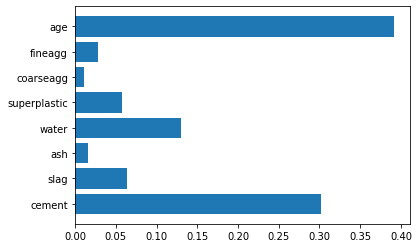

In [103]:
plt.barh(X_train1.columns,gradCV1.best_estimator_.feature_importances_)

<BarContainer object of 7 artists>

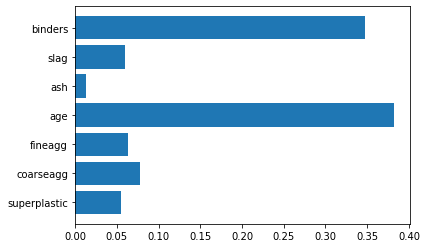

In [104]:
plt.barh(X_train2.columns,gradCV2.best_estimator_.feature_importances_)

<BarContainer object of 7 artists>

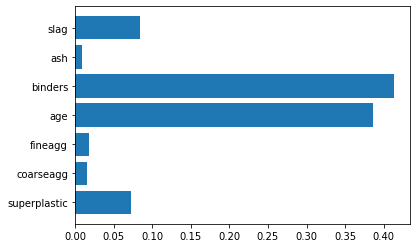

In [105]:
plt.barh(X_train3.columns,gradCV3.best_estimator_.feature_importances_)

<BarContainer object of 32 artists>

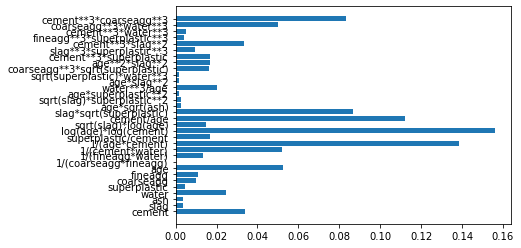

In [106]:
plt.barh(X_train4.columns,gradCV4.best_estimator_.feature_importances_)

<BarContainer object of 8 artists>

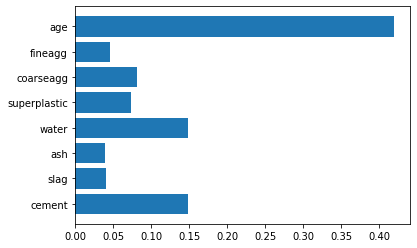

In [107]:
plt.barh(X_train1.columns,xgCV1.best_estimator_.feature_importances_)

<BarContainer object of 7 artists>

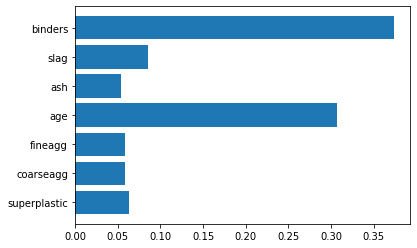

In [108]:
plt.barh(X_train2.columns,xgCV2.best_estimator_.feature_importances_)

<BarContainer object of 7 artists>

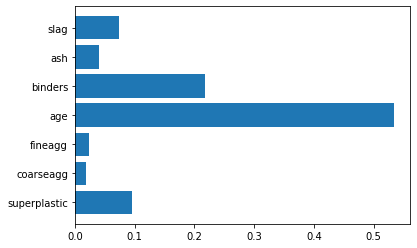

In [109]:
plt.barh(X_train3.columns,xgCV3.best_estimator_.feature_importances_)

<BarContainer object of 32 artists>

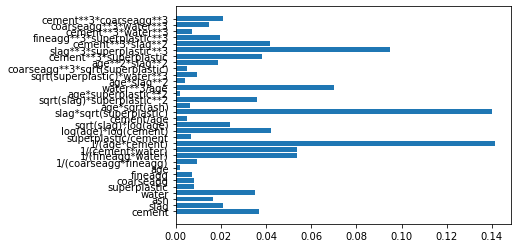

In [110]:
plt.barh(X_train4.columns,xgCV4.best_estimator_.feature_importances_)

As we can see different model has different feature importance. The XGboost model values "age" more than that of "cement" but sklearn gradient boosting values "cement" higher than XGboost model. The graphs also show that all features has atleast some importance. and binder is more important than cement content. Some attributes has very low feature importances but based on trials they contribute to the last bit of performance to get accuracy.. Some features has more importance in some model. some in another model..so i am not dropping any attributes. 

Seems the best estimator is different for different dataset

In [111]:
consolidate11,model=trialscore1('Gradoptimized','original', [gradCV1.best_estimator_], X_train1,y_train1)
consolidate21,model=trialscore1('Gradoptimized','Ratio', [gradCV2.best_estimator_], X_train2,y_train2)
consolidate31,model=trialscore1('Gradoptimized','outlier', [gradCV3.best_estimator_], X_train3,y_train3)
consolidate41,model=trialscore1('Gradoptimized','autofeature', [gradCV4.best_estimator_], X_train4,y_train4)
display(consolidate11)
display(consolidate21)
display(consolidate31)
display(consolidate41)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Gradoptimized,o,4.428956,5.191187,0.92584,0.021966,0.925063


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Gradoptimized,R,4.531014,6.876355,0.923619,0.02344,0.92292


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Gradoptimized,o,4.397008,6.117552,0.926273,0.023029,0.925532


,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,Gradoptimized,a,4.728779,4.855021,0.915621,0.021771,0.911968


In [0]:
result=pd.DataFrame({})
result['XGoriginal']=xgCV1.best_estimator_.predict(X_train1)
result['XGratio']=xgCV2.best_estimator_.predict(X_train2)
result['XGautofeat']=xgCV4.best_estimator_.predict(X_train4)
result['Gradoriginal']=gradCV1.best_estimator_.predict(X_train1)
result['Gradratio']=gradCV2.best_estimator_.predict(X_train2)
result['Gradautofeat']=gradCV4.best_estimator_.predict(X_train4)
result['Y']=np.array(y_train1)



In [113]:
result.head()

,XGoriginal,XGratio,XGautofeat,Gradoriginal,Gradratio,Gradautofeat,Y
0,30.454275,30.270731,30.650614,31.952176,29.895793,29.280062,30.14
1,15.068624,15.544379,15.386858,14.430179,15.717377,13.756221,15.53
2,27.771421,28.263172,28.219841,28.298291,28.555305,25.971337,27.83
3,26.544313,27.778242,27.847086,27.578672,25.436874,26.923399,27.92
4,36.029648,39.486290,39.734924,34.736076,34.597360,33.279208,40.23


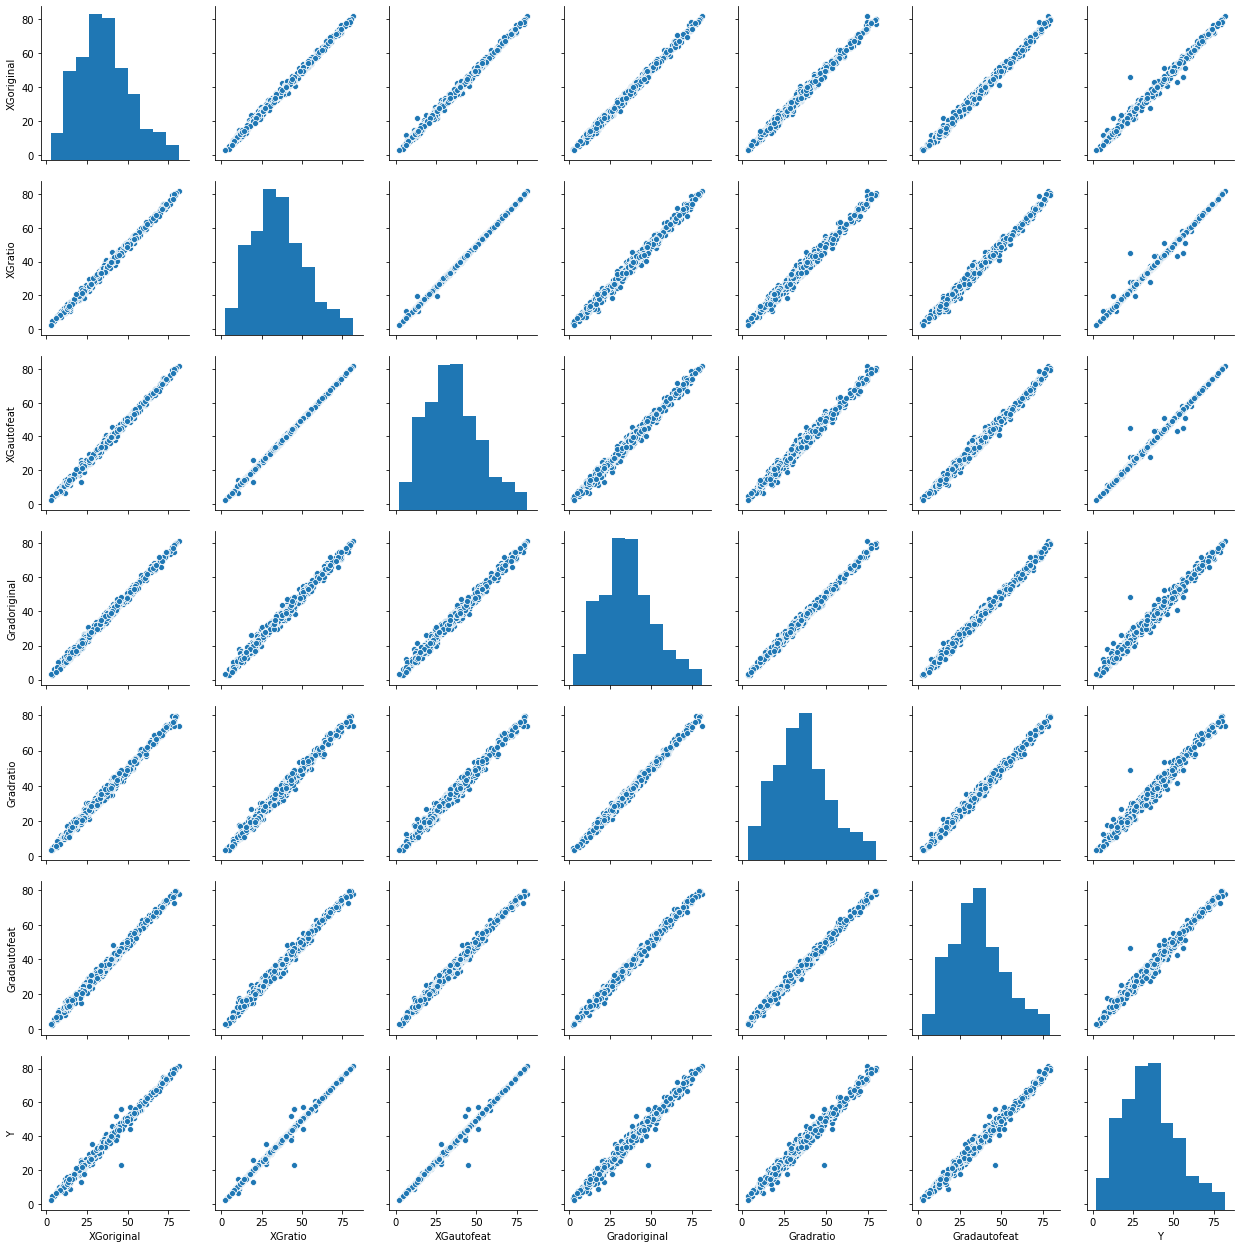

In [114]:
sns.pairplot(result)

The last row of the pair plot show that some points are always predicted wrongly no matter what the model is and feature engineering is.


## lets take Grad ratio model

In [115]:
X_train2[(gradCV2.best_estimator_.predict(X_train2)-y_train2)<-5]

,superplastic,coarseagg,fineagg,age,ash,slag,binders
250,0.003053,0.485738,0.357924,28,0.011164,0.044701,0.849860
349,0.000000,0.470232,0.338042,28,0.000000,0.095863,1.200000
192,0.002529,0.484376,0.319345,28,0.000000,0.058725,0.460317
344,0.003405,0.453121,0.409444,28,0.045630,0.000000,0.874165
147,0.005226,0.472441,0.348149,28,0.054372,0.023980,0.645280
91,0.005124,0.417326,0.333878,7,0.000000,0.083492,0.454771
808,0.005179,0.431774,0.317914,7,0.035274,0.010716,0.363229
1013,0.004796,0.414449,0.352413,28,0.062035,0.008359,0.428969
631,0.005179,0.431774,0.317914,3,0.035274,0.010716,0.363229
303,0.006049,0.408199,0.367727,7,0.040907,0.008704,0.405685


for the for these occasions the error is negative high . 

In [116]:
X=result.iloc[:,:-1]
Y=result.iloc[:,-1]
data='boost1'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,boost1,Linear Regression,1.200583,1.929404,0.994463,0.007895,0.994419
1,boost1,Ridge Regression,1.200572,1.929222,0.994463,0.007894,0.994420
2,boost1,Lasso Regression,1.218429,1.897998,0.994303,0.007751,0.994258
3,boost1,support vector Regressor,13.465049,37.690671,0.331987,0.055668,0.326747
4,boost1,Decision Tree Regressor,1.824786,4.230510,0.987195,0.017315,0.987095
5,boost1,Random Forest Regressor,1.678317,4.139210,0.989009,0.017122,0.988923
6,boost1,Gradient Boosting Regressor,1.704568,4.039737,0.988800,0.016563,0.988712
7,boost1,Adaboost Regressor,2.563204,2.793004,0.975595,0.010109,0.975403
8,boost1,Bagging Regressor,1.676807,4.133466,0.989030,0.017103,0.988944
9,boost1,XGboost,1.671361,3.831963,0.989233,0.015719,0.989148


There is no much variations in the prediction seems both XGboost and sklearn module are doing almost same samples as wrong. lets mix up

0.9873950232851533

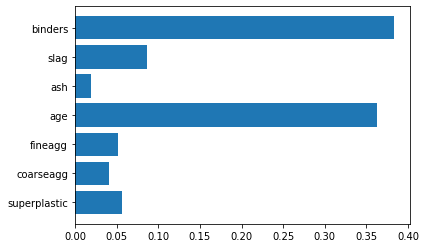

In [117]:
dt=DecisionTreeRegressor(max_depth=50,min_samples_split=5,min_samples_leaf=2,min_impurity_split=0.0001)
dt.fit(X_train2,y_train2)
ada=AdaBoostRegressor(base_estimator=dt,learning_rate=0.2,n_estimators=200)
ada.fit(X_train2,y_train2)
plt.barh(X_train2.columns,ada.feature_importances_)
r2_score(ada.predict(X_train2),y_train2)


0.9681463054472308

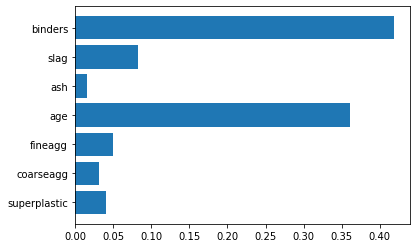

In [118]:
rand=RandomForestRegressor(n_estimators=1000,min_samples_split=5,min_samples_leaf=2,random_state=1)
rand.fit(X_train2,y_train2)
plt.barh(X_train2.columns,rand.feature_importances_)
r2_score(rand.predict(X_train2),y_train2)

Ada boost and Random forest values binders more than that of age. but it values ash very little. lets try dropping ash

0.9672859126261072

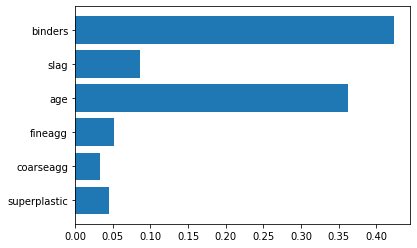

In [119]:
dr=X_train2.drop('ash',axis=1)
rand=RandomForestRegressor(n_estimators=1000,min_samples_split=5,min_samples_leaf=2,random_state=1)
rand.fit(X_train2.drop('ash',axis=1),y_train2)
plt.barh(dr.columns,rand.feature_importances_)
r2_score(rand.predict(X_train2.drop('ash',axis=1)),y_train2)


Lets try dropping coarseagg

0.9650609938564695

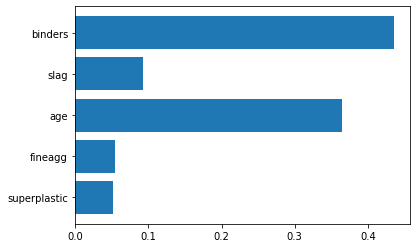

In [120]:
dr=X_train2.drop(['ash','coarseagg'],axis=1)
rand=RandomForestRegressor(n_estimators=1000,min_samples_split=5,min_samples_leaf=2,random_state=1)
rand.fit(dr,y_train2)
plt.barh(dr.columns,rand.feature_importances_)
r2_score(rand.predict(dr),y_train2)

In [0]:
result['ada']=ada.predict(X_train2)
result['randomforest']=rand.predict(dr)

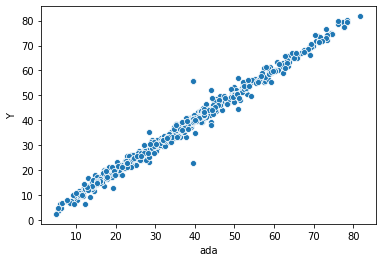

In [122]:
sns.scatterplot(result['ada'],result['Y'])

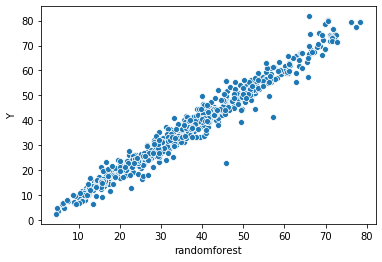

In [123]:
sns.scatterplot(result['randomforest'],result['Y'])

In [124]:
X=result.drop('Y',axis=1)
Y=result['Y']
data='boost2'
consolidate=trialscore(data,names, models, X,Y)
display(consolidate)

,Data,Model,RMSE,RMSE std,R Squared,R Squared std,Adjusted R Squared
0,boost2,Linear Regression,1.245031,2.143379,0.994041,0.008771,0.993979
1,boost2,Ridge Regression,1.244924,2.142119,0.994042,0.008766,0.993980
2,boost2,Lasso Regression,1.218429,1.897998,0.994303,0.007751,0.994243
3,boost2,support vector Regressor,14.100032,37.313214,0.265759,0.045524,0.258061
4,boost2,Decision Tree Regressor,1.836058,4.226917,0.987062,0.017280,0.986926
5,boost2,Random Forest Regressor,1.672149,4.137677,0.989079,0.017117,0.988965
6,boost2,Gradient Boosting Regressor,1.730092,4.119397,0.988486,0.016868,0.988366
7,boost2,Adaboost Regressor,2.334127,2.609168,0.979314,0.010970,0.979097
8,boost2,Bagging Regressor,1.674125,4.138541,0.989050,0.017118,0.988935
9,boost2,XGboost,1.699707,3.943069,0.988883,0.016149,0.988767


# Based on the results I propose 2 models 

## I) gradCV2 as the model because 

1) Could genralize well as one feature is reduced

2) Ratio of features are used

3) compared to gradCV3,gradCV4 good distribution of importances. as dataset3 is     less data due to outlier removal and data4 has larger number of features, so    prone to over fitting

## II) linear model using boost1 because

1) I believe it could boost the results by capturing the trend between prediction and reults
 

In [0]:
testresult=pd.DataFrame({})
testresult['XGoriginal']=xgCV1.best_estimator_.predict(X_test1)
testresult['XGratio']=xgCV2.best_estimator_.predict(X_test2)
testresult['XGautofeat']=xgCV4.best_estimator_.predict(X_test4)
testresult['Gradoriginal']=gradCV1.best_estimator_.predict(X_test1)
testresult['Gradratio']=gradCV2.best_estimator_.predict(X_test2)
testresult['Gradautofeat']=gradCV4.best_estimator_.predict(X_test4)
testresult['ada']=ada.predict(X_test2)
testresult['randomforest']=rand.predict(X_test2.drop(['ash','coarseagg'],axis=1))
testresult['Y']=np.array(y_test1)

In [128]:
print('model 1 (gradientboosting) test results:',r2_score(gradCV2.predict(X_test2),y_test2))
X=result.drop(['Y','ada','randomforest'],axis=1)
Y=result['Y']
lm=LinearRegression()
lm.fit(X,Y)
print('model 2 (linear boosting on results) test results:',r2_score(lm.predict(testresult.drop(['Y','ada','randomforest'],axis=1)),testresult['Y']))



model 1 (gradientboosting) test results: 0.9275129368804277
model 2 (linear boosting on results) test results: 0.924464872915746


Good. the results seems good with test data. 
no over fitting as variance is not high. i.e, the train and test predicitons are not farther apart

## Lets find out the range for 95% confidence interval

# Model1

In [0]:
model1con=gradCV2.best_estimator_

In [0]:
d1=d.copy()
num=['cement','ash','slag','coarseagg','superplastic','fineagg']
k=d1['cement']+d1['ash']+d1['slag']+d1['coarseagg']+d1['superplastic']+d1['fineagg']
d1['binders']=d1['water']/(d1['cement'])
for f in num:
    d1[f]=np.divide(d[f],k)
data=d1.drop(['cement','water'],axis=1)
values = data.values

from sklearn.utils import resample
# configure bootstrap
n_iterations = 1000              # Number of bootstrap samples to create
n_size = int(len(data) * 0.50)    # picking only 50 % of the given data in every bootstrap sample

# run bootstrap
stats = list()
for i in range(n_iterations):
	# prepare train and test sets
	train = resample(values, n_samples=n_size)  # Sampling with replacement 
	test = np.array([x for x in values if x.tolist() not in train.tolist()])  # picking rest of the data not considered in sample
    # fit model
	model1con=gradCV2.best_estimator_
	model1con.fit(train[:,:-1], train[:,-1])
    # evaluate model
	predictions = model1con.predict(test[:,:-1])
	score = r2_score(test[:,-1], predictions)    # caution, overall accuracy score can mislead when classes are imbalanced
	stats.append(score)

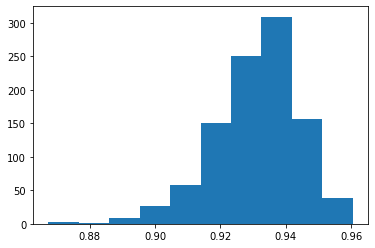

95.0 confidence interval 90.2% and 95.2%


In [131]:
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95                             # for 95% confidence 
p = ((1.0-alpha)/2.0) * 100              # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

# Model 2

In [0]:
d1=result.append(testresult)
data=d1.drop(['ada','randomforest'],axis=1)
values=data.values

from sklearn.utils import resample
# configure bootstrap
n_iterations = 1000              # Number of bootstrap samples to create
n_size = int(len(data) * 0.5)    # picking only 50 % of the given data in every bootstrap sample

# run bootstrap
stats2 = list()
for i in range(n_iterations):
	# prepare train and test sets
	train = resample(values, n_samples=n_size)  # Sampling with replacement 
	test = np.array([x for x in values if x.tolist() not in train.tolist()])  # picking rest of the data not considered in sample
    # fit model
	lm1=LinearRegression()
	lm1.fit(train[:,:-1], train[:,-1])
    # evaluate model
	predictions = lm1.predict(test[:,:-1])
	score = r2_score(test[:,-1], predictions)    # caution, overall accuracy score can mislead when classes are imbalanced
	stats2.append(score)

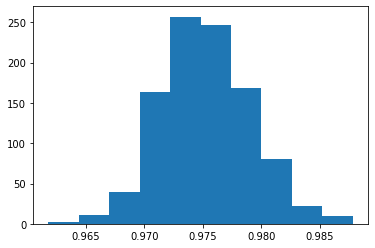

95.0 confidence interval 96.8% and 98.3%


In [136]:
# plot scores
plt.hist(stats2)
plt.show()
# confidence intervals
alpha = 0.95                             # for 95% confidence 
p = ((1.0-alpha)/2.0) * 100              # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats2, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats2, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

# Lets try the gradCV3 model to know how it performs

In [0]:
q1=d.quantile(0.25)
q3=d.quantile(0.75)
iqr=q3-q1
df_0=d[~((d<(q1-1.5*iqr))|(d>(q3+1.5*iqr))).any(axis=1)]
df_final=df_0.reset_index(drop=True)
d1=df_final.copy()
d1['binders']=d1['water']/(d1['cement'])

data=d1.drop(['cement','water'],axis=1)
values = data.values

from sklearn.utils import resample
# configure bootstrap
n_iterations = 1000              # Number of bootstrap samples to create
n_size = int(len(data) * 0.50)    # picking only 50 % of the given data in every bootstrap sample

# run bootstrap
stats1 = list()
for i in range(n_iterations):
	# prepare train and test sets
	train = resample(values, n_samples=n_size)  # Sampling with replacement 
	test = np.array([x for x in values if x.tolist() not in train.tolist()])  # picking rest of the data not considered in sample
    # fit model
	model1con=gradCV3.best_estimator_
	model1con.fit(train[:,:-1], train[:,-1])
    # evaluate model
	predictions = model1con.predict(test[:,:-1])
	score = r2_score(test[:,-1], predictions)    # caution, overall accuracy score can mislead when classes are imbalanced
	stats1.append(score)


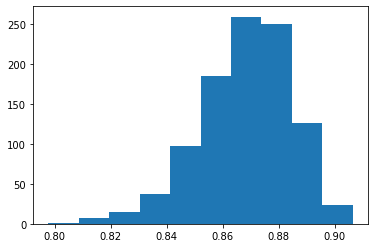

95.0 confidence interval 83.3% and 89.5%


In [138]:
# plot scores
plt.hist(stats1)
plt.show()
# confidence intervals
alpha = 0.95                             # for 95% confidence 
p = ((1.0-alpha)/2.0) * 100              # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats1, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats1, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

this model has less r2 value for 95% confident.just as expected

# Summary

The r2 of the proposed model with 95% confidence and using only 50 % of data

model 1 : 90.2% to 95.2%

model 2 : 96.8% to 98.3%

since we are using  50% data for training and 50% for testing and the above results are for 95% confidence shows that the models are not over fitted.

I could have dropped features using their importance but different models showed different proportion of importance between attributes. some feature which is of low importance for some model had some considerable importance in other. so decided to work with full features

There were 25 duplicate datasets.

Outliers exist. but they too contribute to the results. We tried that 90% confidence intervel on outlier removed data it shows over fitting of model

Thus we conclude the project with two models. 

model 1 - gradient boosting with engineered features

model 2 - Linear regression on results from different models